# Appendix A: a method for imputing values for censored data

## Overview

Appendix A focuses on imputing values for the records in the housing dataset with a censored housing_median_age.  This variable is capped at age 52, with approximately 6% of the data (1,268 records) having this cap.  

Appendix B focuses on imputing values for the records with a capped median_house_value.

Values are imputed using a Gibbs sampler.  It involves running, in this case, four random walks simultaneously.  In each, the first step is to randomly assign values from the expected imputation range to the records with censored values.  The expected imputation range for the capped housing median age values is from 52 to around 83 years.  The new set of housing median age values is then regressed on the predictors from a model previously constructed with the original housing_median_age values.  (I.e., the model the Gibbs sampler makes use of is one which is constructed with the capped values in place.)  New predictions are obtained using coefficients randomly sampled from the uncertainty distributions of the model's parameters.  With the new predictions, another model is obtained.  We repeat this process many times, essentially until we see the separate random walks converge in their estimates of the parameters.  The Gibbs sampler output includes predictions for the imputed values that we need.  These predictions are normally distributed, and the spread of the distribution depends on the R-squared of the model we employ and the range in which we expected the imputed values to lie.  The smaller we make this range, the smaller the spread of our imputed values.  The greater the R-squared of the model we rely on, the smaller the spread of the imputed values.  While smaller spreads are preferable, we do not want to choose a range for the imputed values that is likely to capture only 80% of the size of the actual range.  E.g., for housing_median_age, we expect that there are districts with an age of 65, but it is not so clear that we will find many with an age > 85.  If we expect that only around 1% of the districts have an age > 78, then we will end up with a much better set of predictions, on average, keeping the upper limit of the imputation range at 78 or slightly below.

Because the models in Appendix A and Appendix B assume that the response variable is normally distributed, the Gibbs samplers relying on these models will always generate predictions which are normally distributed around a mean.  But this shape for the imputed values is not what we necessarily expect to see.  In Section 1 below, the analysis aims to provide a clearer picture of what this shape might be; it provides predictions for the location of the mean and the median of the actual, unobserved values of the censored records.  In Section 2 these predictions are then used to adjust the output from the Gibbs sampler.  Both here and in Part01 I then check that the adjustment to the Gibbs sampler output is still consistent with the data.  (There are 2 distinct validity checks.)

In Appendix C, I look at the degree to which the imputed values reduce the noise found in the capped data.


                                      * * * * *
                                      

# Section 1: Get predictions for medians and means

We want our imputed values to have a distribution similar to that which the actual, unobserved values are likely to have.  Because the imputation range is the tail of the distribution of ages, we have a general idea of what the shape of the distribution will look like: the frequency counts will almost certainly decrease as we move further to the right, and in such a way that the median of the distribution will lie somewhere to the left of the mean.  In this instance we can rely on historical knowledge for a sense of how far the tail might extend to the right, and what the upper limit might be for the vast majority of housing median ages.  We can make use of the data we already have, in combination with our hypothesized distribution for the imputed values, to get a good idea of where the mean and the median of the distribution might lie.  This section shows one way we can get good predictions for the mean and median.

                                        * * * * *

In [ ]:
# Load some of the packages we will use.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm) 


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# Start with the 20.6K records in housing_cleaned_v02.csv.  This
# is the data I start with at the beginning of Section 2 of Part01.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

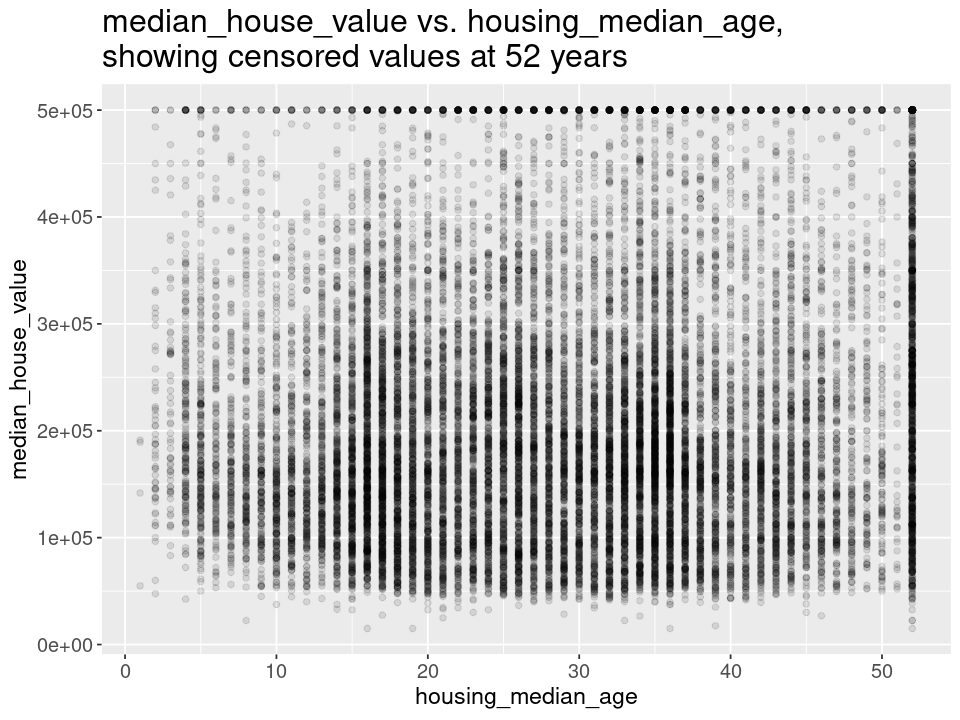

In [4]:
# Plot of median_house_value vs. housing_median_age. 
# 6.15% of the data is censored at age 52.
# median_house_value is also censored at 500K.

options(repr.plot.width= 8, repr.plot.height= 6)

p <- ggplot(dat, aes(housing_median_age, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("housing_median_age") + ylab("median_house_value") +
  ggtitle("median_house_value vs. housing_median_age, 
showing censored values at 52 years") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


In [5]:
# There are 1268 records, or districts, with a 
# censored housing_median_age.

nrow(dat[which(dat$housing_median_age >= 52),])


[1] 1268

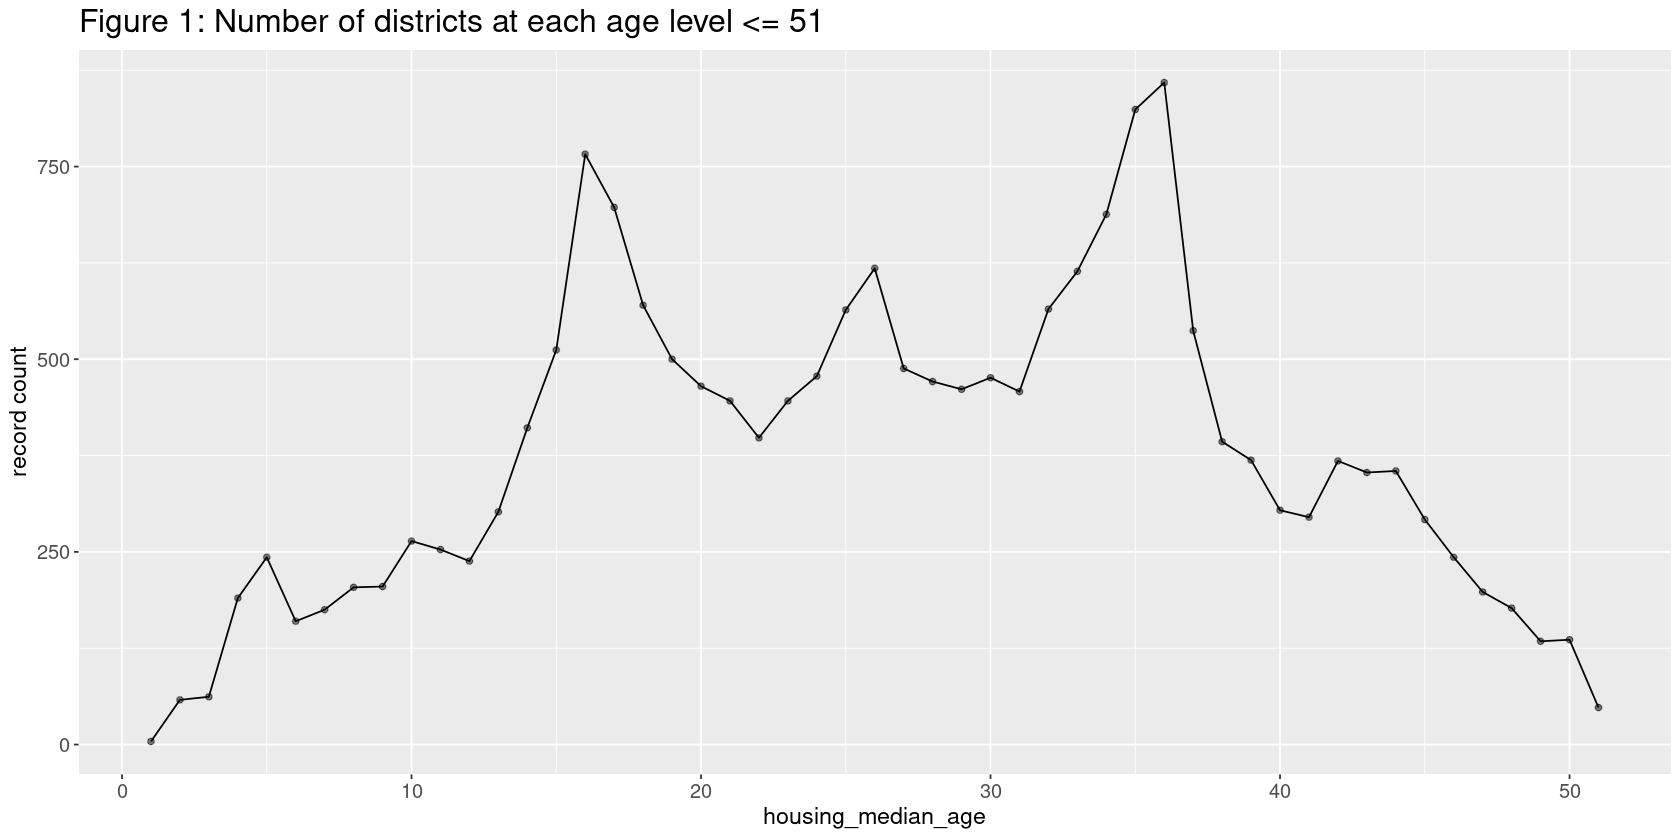

In [6]:
# Construct a dataframe for plotting the number of districts
# at each age level.  This will give us a very general idea
# of what the distribution of counts might look like for the
# 1268 records which need an imputed value.  We are interested
# in the general shape of the distribution when age is > 43.

ans <- table(as.factor(dat$housing_median_age))[1:51]
df_age <- rep(NA, 2 * length(ans))
dim(df_age) <- c(length(ans), 2)
df_age <- as.data.frame(df_age)
colnames(df_age) <- c("age", "count")
df_age$age <- as.numeric(names(ans))
df_age$count <- as.numeric(ans)


options(repr.plot.width= 14, repr.plot.height= 7)

p <- ggplot(df_age, aes(age, count)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 1: Number of districts at each age level <= 51") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [7]:
tail(df_age)


,age,count
,<dbl>,<dbl>
46,46,243
47,47,198
48,48,177
49,49,134
50,50,136
51,51,48


In [8]:
round(sd(df_age$count),1)


[1] 203.3

## Hypothesized distribution for the actual, unobserved values

In [9]:
# Creating an example distribution beyond age 51 will help us
# get a sense of what predictions are plausible for the
# mean and median of the true, unobserved ages beyond age 51.
# See plot that follows.

# Possible counts for ages 52:82.  We expect the counts
# to decrease as we move further to the right.  The first
# distribution (mydist vector) has a smaller mean and median.
# mydist <- c(130, 125, 120, 112, 108, 100, 93, 80, 73, 66,
#             60, 49, 40, 35, 30, 22, 15, 0, 0, 5, 0, 0, 3,
#             0, 0, 0, 1, 0, 0, 0, 1)
mydist <- c(120, 105, 100, 112, 98, 90, 83, 80, 83, 71,
            65, 54, 45, 35, 30, 32, 25, 15, 5, 5, 3, 2, 3,
            0, 2, 2, 1, 1, 0, 0, 1)
sum(mydist)
# 1268

observed <- as.numeric(df_age[which(df_age$age >= 22),]$count)

all <- c(observed, mydist)
n <- length(22:82)

dftmp <- rep(NA, 2 * n)
dim(dftmp) <- c(n, 2)
dftmp <- as.data.frame(dftmp)
colnames(dftmp) <- c("age", "count")
dftmp$age <- 22:82
dftmp$count <- all


[1] 1268

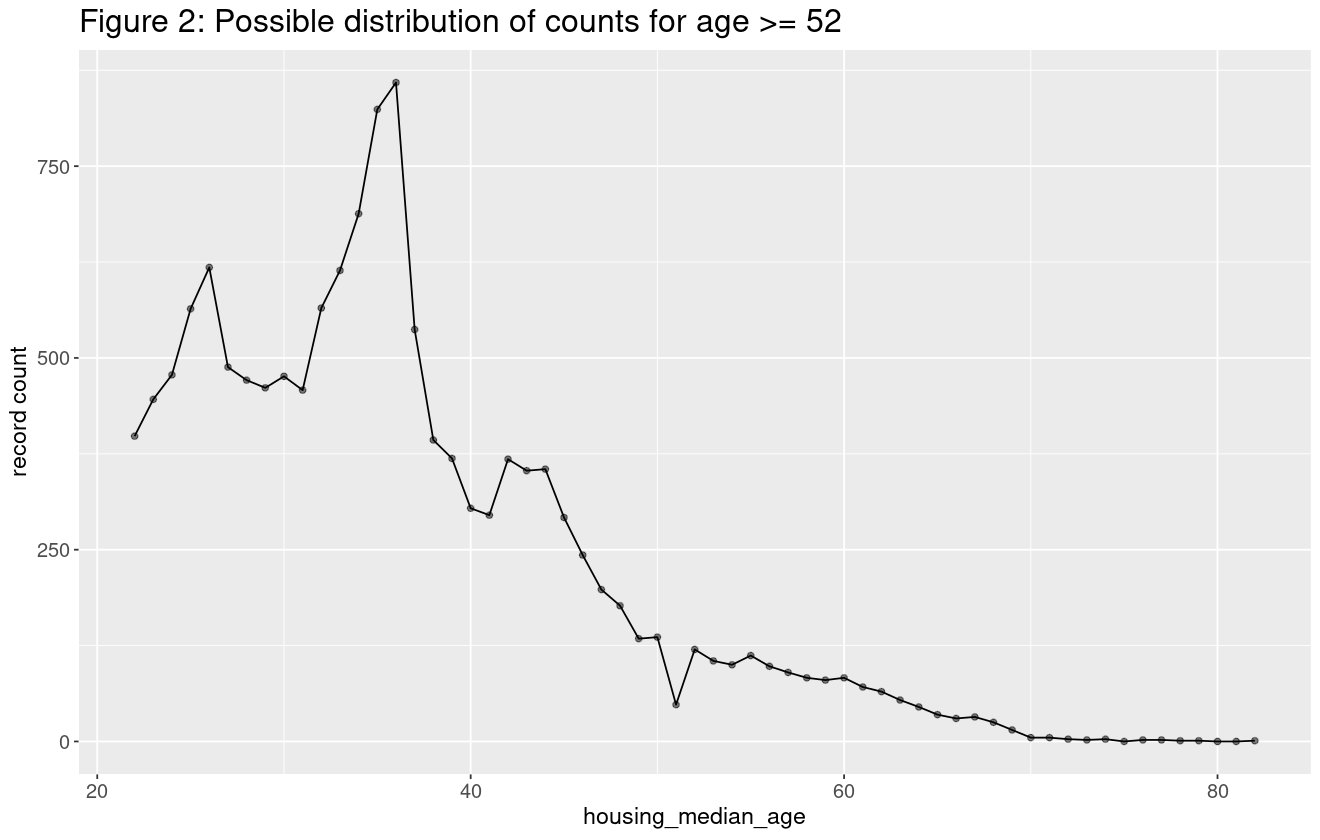

In [10]:
# Plot to show possible distribution of 1268 districts 
# beyond age 51.

options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(dftmp, aes(age, count)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 2: Possible distribution of counts for age >= 52") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [11]:
#  The sharp drop in the counts from ages 36 to 51 leads me
# to think that the counts from age 52 on will drop even
# more quickly than what is shown in the above plot.  E.g.,
# if nearly all of the 1268 censored districts have ages
# <= 63, then the mean and median shown here
# (58.4 and 58 respectively) are likely too high. 

round(sum(mydist * 52:82)/sum(mydist), 1)
# 58.4
round(median(rep(52:82, mydist)), 1)
# 58


[1] 58.4

[1] 58


 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71 
120 105 100 112  98  90  83  80  83  71  65  54  45  35  30  32  25  15   5   5 
 72  73  74 
  3   2   3 

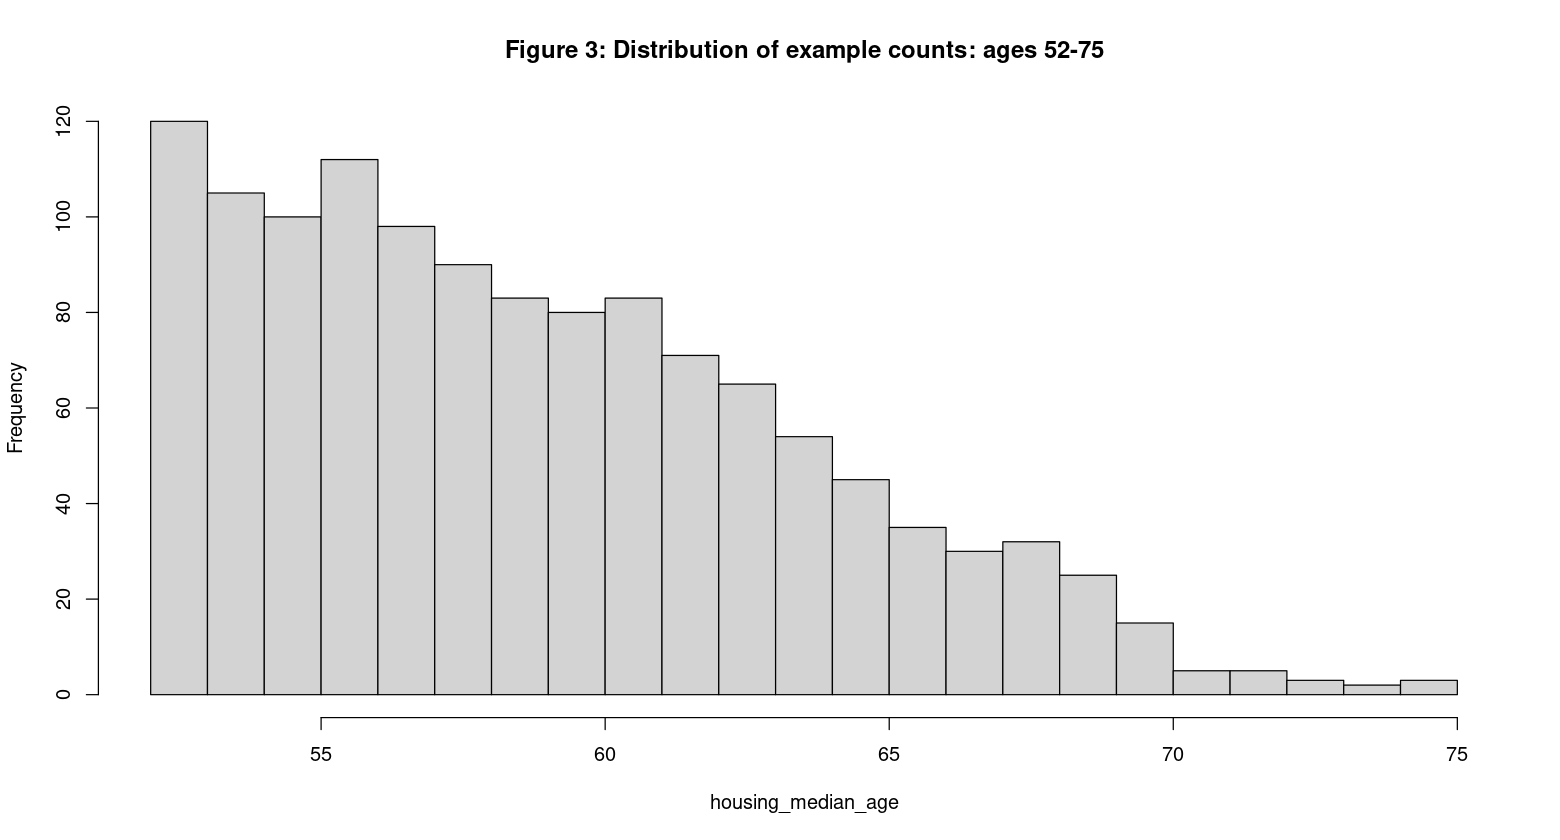

In [13]:
# The histogram below shows the counts for mydist; this
# is a close-up of the far right of Figure 2.

tbl <- table(as.factor(rep(52:75, mydist[1:24]))); tbl

options(repr.plot.width= 13, repr.plot.height= 7)

# Add 0.02 to each of the ages so that the histogram
# looks right.
hist(rep(52:75, mydist[1:24]) + 0.02, breaks=18, xlab="housing_median_age",
     main="Figure 3: Distribution of example counts: ages 52-75")


In [ ]:
### COMMENTS for Figures 1, 2, and 3:

############################################################# 

# In Figure 1 above, from age 36 onwards, the trend is
# a very sharp drop in the counts.  For age 52 and beyond, 
# the number of districts we would expect to see for each
# age level is < 177, more likely < 140.  That number is 
# likely to decrease relatively quickly the further out we 
# go from age 52.  I have tried to capture one plausible
# scenario for the tailing off of the counts; this is
# shown in Figures 2 and 3.

# The sharp drop in the counts from age 36 onwards is something
# to keep in mind when predicting for the mean and median.
# There are only 1268 districts with an age >= 52. In Figure 2 
# the downward trend roughly approximates a negative exponential
# curve.  We can see in Figure 3 how the counts might approximate a
# half-normal curve for ages > 51.  If the shape of the distribution
# of actual counts is half-normal, it would mean that the mean and 
# median we currently have for mydist are a bit high.  Of course,
# the mean might stay around 58 if we have districts even
# further to the right, beyond age 82.  But outliers will not  
# change the median much, if at all.

# A median around 56-57 looks to be very plausible.  A mean 
# slightly above this is also quite plausible.  It does not
# appear plausible, to me anyway, that we would have a median
# greater than 59 or a mean greater than 61.

# The above example distribution is an important reference.
# It provides us with our first prediction for the mean.

#############################################################



## Get a 2nd prediction for the mean and median using shift increment ratios

Some trial and error was required before I found another way to obtain a plausible prediction of the mean of the actual, unobserved age values.  I use what I call "shift-increment" ratios to do this.

For the first set of ratios below, I look out 1.6 times (1.6X) the value of the starting point, or cap.  The multiplier of 1.6 is used because it captures most of the expected imputation range.  (Note that 1.6 * 52 = 83, and 83 is my expected upper limit for the imputation range.)  For example, if we artificially capped our data at year 32, I am interested in the mean and median of the counts in the range \[32, 51\].  As we see, the 1.6X ratios are not nearly as helpful as the 31-year ratios.  (31 + 52 = 83; we do not need to make the span 31 years, but when we make it so, we capture the entire expected range for the imputed values capped at age 52.)  Using the 31-year ratios, we can make a fairly good prediction for the mean of the actual, unobserved values with an age >= 52.  We can then use this prediction to help us improve upon the Gibbs sampler output when imputing values for the records with a censored housing_median_age.

The 1.6X ratios are presented merely for pedagogic purposes.  By presenting them, we can get a sense of just how much better the 31-year ratios are.

We see below that getting a good prediction for the median is much harder.  I end up abandoning this effort.  We know from the hypothesized distribution that the median should be less than the mean, but without a good prediction we do not know by how much.

Compare the imputation done below with that in Appendix B.  In Appendix B I learn that the size of the moving window is far more important than I first realized.  The larger we make the span, the larger our ratios; this in turn means that if the span is too large for each of the computed ratios we rely on for making our prediction at age 52, then our prediction will be too large.  Fortunately, this does not happen here, for we obtain a prediction (mean = 57) that is consistent with that from our hypothesized distribution (mean = 58), and in fact less.


                                    * * * * *



In [17]:
mean_ratios <- median_ratios <- rep(NA, length(2:32))
means <- medians <- rep(NA, length(2:32))
rcd_count <- rep(NA, length(2:32))


# We look out 1.6X the value of the cap.  Why 1.6 when 1.6*52
# is only 83 and there might be a few districts with a
# housing median age > 83?  There are three reasons: (i) the
# more we increase the span, the fewer datapoints we have to
# work with for understanding the pattern/trajectory of the 
# means and medians; the larger the span the fewer the datapoints
# because we run into the hypothesized distribution more quickly;
# and (ii) the further out we set the upper limit, the larger the
# standard errors are for the imputed values; the large standard 
# errors are not helpful when we expect < 1% of the true, 
# unobserved ages for the 1268 records to be > 83;
# this expectation ought to be incorporated into the  imputation
# process; and (iii) even if 83 is a bit too low for the upper 
# limit, this will affect the mean of the distribution in the 
# range of imputation but not the median, given the small number
# of districts we expect to find beyond this upper limit.  This 
# is why we also want to collect information on the medians.

span <- 1.6

for(cur_age in 2:32) {
    
    agevals <- as.numeric(dat[which((dat$housing_median_age >= cur_age) &
                        (dat$housing_median_age <= round(span*cur_age))),
                  c("housing_median_age")])
    counts <- as.numeric(table(as.factor(agevals)))
    rcd_count[cur_age - 1] <- sum(counts)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 1] <- round(age_mean/cur_age, 3)
    means[cur_age - 1] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 1] <- round(age_median/cur_age, 3)
    medians[cur_age - 1] <- age_median
}

paste0("These are the 1.6X shift increments for the means: ")
names(mean_ratios) <- as.character(2:32)
print(mean_ratios)


df_ratios <- rep(NA, 6*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 6)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_ratios$age <- 2:32
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$median_ratio <- median_ratios
df_ratios$mean <- means
df_ratios$median <- medians


[1] "These are the 1.6X shift increments for the means: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
1.258 1.455 1.237 1.287 1.373 1.314 1.337 1.315 1.380 1.391 1.336 1.316 1.270 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.272 1.294 1.288 1.306 1.294 1.307 1.328 1.321 1.330 1.306 1.295 1.290 1.277 
   28    29    30    31    32 
1.273 1.254 1.242 1.229 1.206 


In [18]:
summary(as.numeric(rcd_count))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    120    2210    5811    5203    8265    8788 

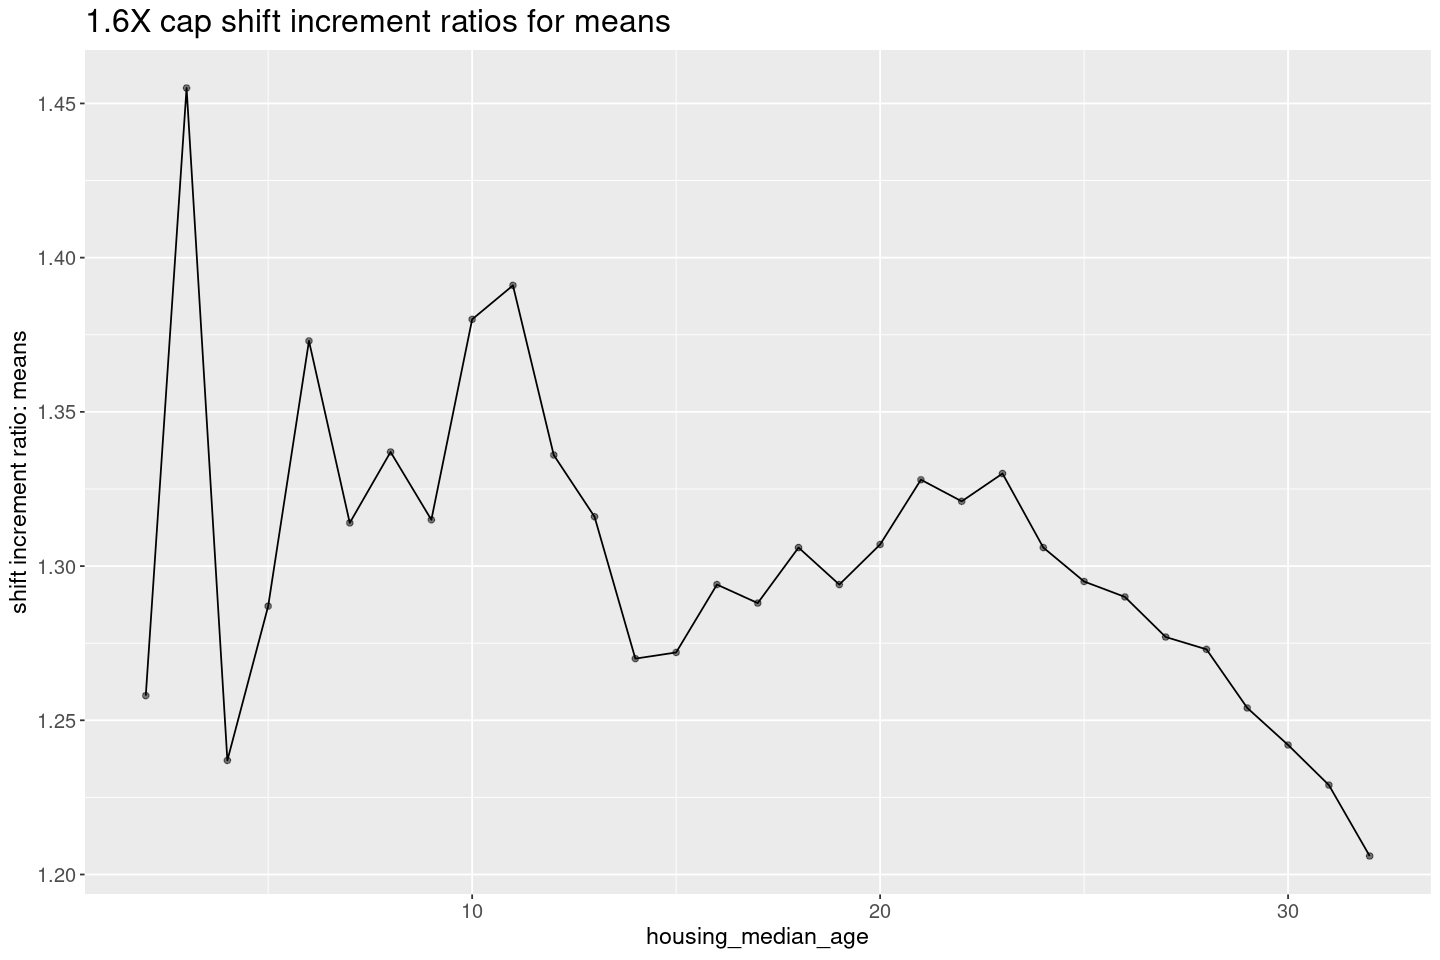

In [19]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("shift increment ratio: means") +
  geom_line() +
  ggtitle("1.6X cap shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENTS:

# The plot for the means shows a strong downward trend when 
# the cap is >= 23.  The numbers strongly suggest that the 
# shift increment ratio for the range [52, 83] will be > 1
# and < 1.2.  The mean can never be < 1.

# The shift increment ratio for age 32 is 1.206.  The corres-
# ponding ratio for age 52 will almost certainly be < 1.2 due
# to the downward trend.  Notice that 1.2 * 52 = 62.4.  As 
# already mentioned in the comments regarding the counts, a 
# mean > 61 seems implausible; this judgment is based on the
# example distribution (mydist).


In [20]:
# The above ratios are based on very different counts.  When
# modeling we will thus likely need to make use of weighted
# least squares.

df_ratios$rcds


[1]  120  495  593  782 1008 1101 1466 1673 2746 3749 3996 4669 4765 5278 5948
[16] 5670 5905 5811 6334 7171 7549 8547 8494 8689 8788 8523 8682 8454 8368 8162
[31] 7752

In [ ]:
### COMMENT:

# Since there is a better way to obtain shift-increment ratios for
# modeling, I will not try to model the trend from age 23 onwards
# in the above plot.

# The reason for showing the 1.6X shift-increment ratios is simply
# pedagogic.  These are the ratios I would like to use (for they 
# avoid the problem that I run into in Appendix B) but do not because
# they do not yield an obvious pattern, or trend, one which also
# avoids the problem of predictions falling below 1.


### Compute 1.6X shift increment ratios for the medians

We would like to also have a prediction for the median because the mean is not robust to outliers and I need to somewhat arbitrarily set an upper limit when I run the Gibbs sampler that will generate our imputed values.  The lower I can set the upper limit, the lower the standard errors for the imputed values.  In other words, the lower I can set the upper limit (up to a point, of course), the better chance I have of improving the accuracy of the predictions for the imputed values.  But the more I adjust the upper limit for the Gibbs sampler, the less we can rely on the predicted mean for an understanding of the distribution of the actual, unobserved values.  This is where the median can help us.  (As we will see, the Gibbs sampler yields a mean for the imputed values at around the halfway point between the lower and upper limits.  Here the lower limit is the cap---age 52.)


                                   * * * * *

In [21]:
paste0("These are the 1.6X shift increments for the medians: ")
names(median_ratios) <- as.character(2:32)
print(median_ratios)


[1] "These are the 1.6X shift increments for the medians: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
1.500 1.333 1.250 1.200 1.333 1.286 1.375 1.333 1.400 1.455 1.333 1.308 1.214 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.267 1.250 1.294 1.333 1.316 1.300 1.333 1.318 1.348 1.333 1.320 1.308 1.296 
   28    29    30    31    32 
1.250 1.241 1.200 1.194 1.156 


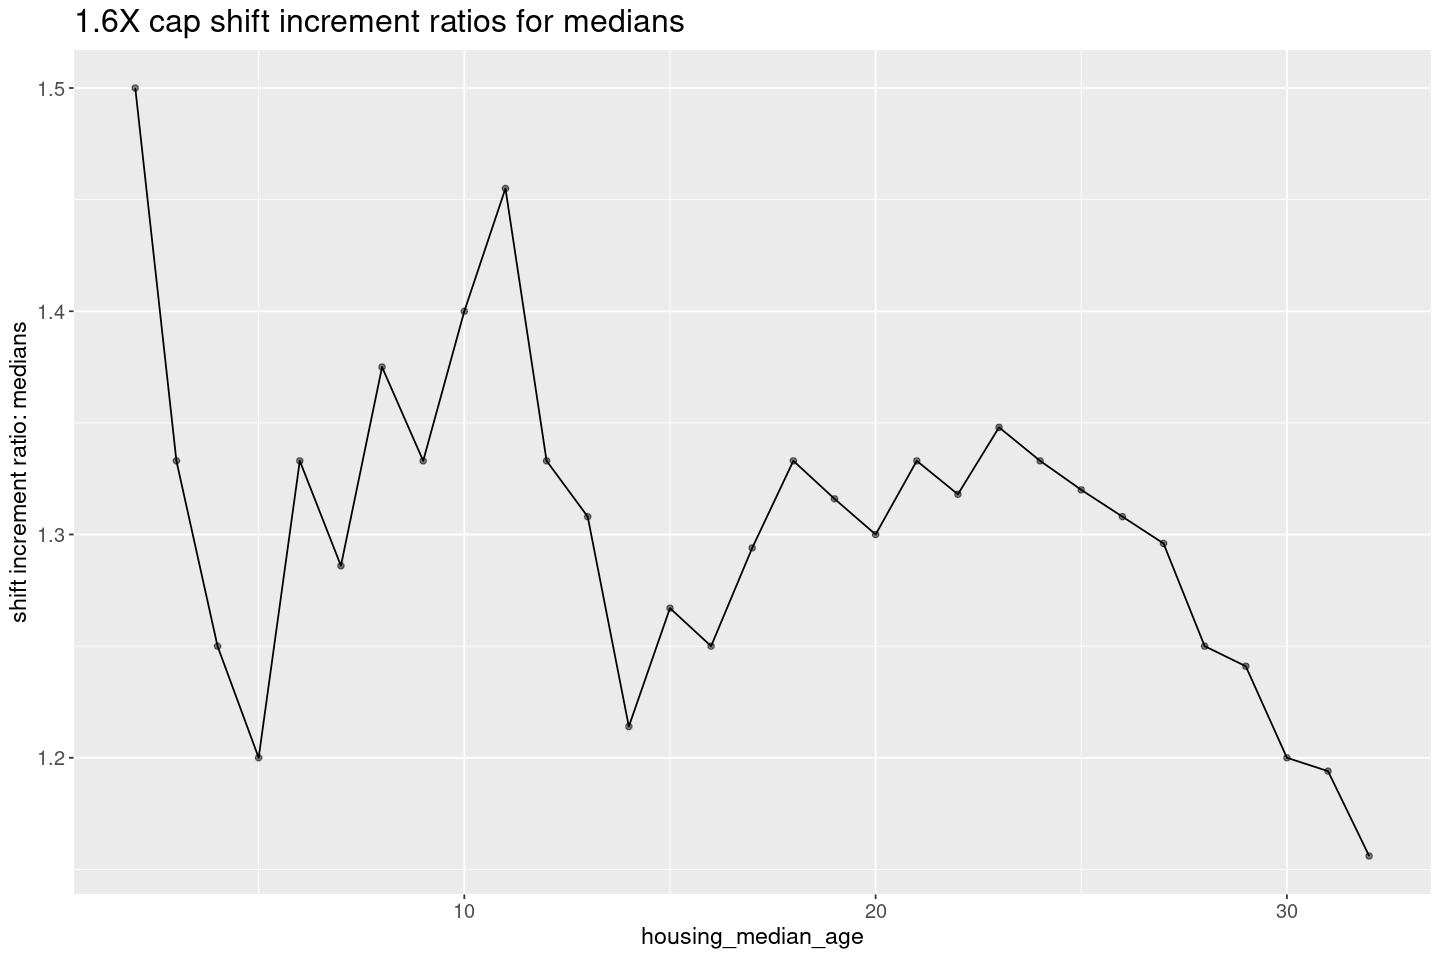

In [22]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(age, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("shift increment ratio: medians") +
  geom_line() +
  ggtitle("1.6X cap shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# Like the plot for the means, the plot for the median ratios
# has a strong downward trend when the cap is >= 23.  The 
# numbers strongly suggest that the shift increment ratio for
# the range [52, 83] will be > 1 and < 1.15.  The median ratio
# can never be < 1.

# Note that 1.15 * 52 = 59.8 < 60.  This is important when we
# consider the plausibility of the predictions below.


### Use a 31-year span for computing shift-increment ratios

Repeat much of the above, but instead of looking out 1.6X the age level, use a sliding window with a span of 31 years.  (I use 31 for the span because 52 + 31 = 83 and 1.6 * 52 = 83 and 83 is about as far out as I think the predictions ought to go.  I need to look out far enough to have stable measures of the mean and median.)  In the following I slide the 31-year window up to age 30, meaning that I make use of part of the hypothesized distribution in the imputation range.  Doing this will give us much more accurate predictions of the mean and median as long as our hypothesized distribution roughly resembles the distribution of the actual, unobserved values.  Of course, if our hypothesized distribution roughly resembles the distribution of the actual, unobserved values, we can simply rely on the predictions for the mean and median that we already have from that distribution.

This second method is a way to confirm the predictions we already have.

I do not find out until I apply the same method in Appendix B that it is simply a matter of luck that I get a plausible prediction for the mean using a 31-year span.  This span is too large for all of the datapoints used in the models that follow, meaning that all of the ratios are larger than what they should be if I had used the "correct" window size (which, for each age value, would be 1.6 times the age value).  In this instance I get a plausible prediction for the mean despite the large ratios because the overall downward trend in the curve is strong enough to compensate.  We see in the models below for predicting the median that the downward trend is strong enough, in fact, to give us a prediction below 1 despite the fact that the ratio can never be < 1.  This is probably due to the fact that the median ratios are less affected than those for the means by the size of the window span.


In sum, this second method of obtaining a prediction for the mean carries less weight than the predictions we have for the mean and median from our hypothesized distribution.  Initially, I thought this second method deserved greater priority.  It would deserve such if we could have both the smooth curve and a 1.6X window at each measurement point but, as we see above, this is not to be.  Note that if I reduce the 31-year span to, say, 24 years---a number which is still too large for many of the age measurement points---then my prediction for age 52 is for a 24-year span and not the 31-year span I am really interested in.  *The aim of this second method, then, can only be to confirm the predictions we already have.*  If there is inconsistency, we have to stick with the first set of predictions based on the hypothesized distribution.  What the second method does give us, regardless, is a very rough sense of the uncertainty that may be tied to the predictions we obtained from the hypothesized distribution.  This is important to have.



                                    * * * * *

In [13]:
# Combine the counts from the hypothesized distribution with the
# counts <= age 51.  

all_age_vals <- c(dat[which(dat$housing_median_age <= 51), c("housing_median_age")],
                        rep(52:82, mydist))
(all_counts <- table(as.factor(all_age_vals)))



  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  4  58  62 190 243 160 175 204 205 264 253 238 302 411 512 766 697 570 500 465 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
446 398 446 478 564 618 488 471 461 476 458 565 614 688 824 859 537 393 369 304 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
295 368 353 355 292 243 198 177 134 136  48 120 105 100 112  98  90  83  80  83 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  76  77  78  79  82 
 71  65  54  45  35  30  32  25  15   5   5   3   2   3   2   2   1   1   1 

In [14]:
# Get means and medians of the age values, 
# looking out 31 years. 

mean_ratios <- median_ratios <- rep(NA, length(5:30))
means <- medians <- rep(NA, length(5:30))
rcd_count <- rep(NA, length(5:30))

span <- 31
for(cur_age in 5:30) {
    
    agevals <- rep(cur_age:(span + cur_age), 
                   as.numeric(all_counts[cur_age:(span + cur_age)]))
    counts <- as.numeric(all_counts[cur_age:(span + cur_age)])
    rcd_count[cur_age - 4] <- sum(counts)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 4] <- round(age_mean/cur_age, 3)
    means[cur_age - 4] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 4] <- round(age_median/cur_age, 3)
    medians[cur_age - 4] <- age_median
}

paste0("These are the 31-year shift increments for the means: ")
names(mean_ratios) <- as.character(5:30)
print(mean_ratios)


df_rat02 <- rep(NA, 6*length(mean_ratios))
dim(df_rat02) <- c(length(mean_ratios), 6)
df_rat02 <- as.data.frame(df_rat02)
colnames(df_rat02) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_rat02$age <- 5:30
df_rat02$rcds <- rcd_count
df_rat02$mean_ratio <- mean_ratios
df_rat02$median_ratio <- median_ratios
df_rat02$mean <- means
df_rat02$median <- medians


[1] "These are the 31-year shift increments for the means: "

    5     6     7     8     9    10    11    12    13    14    15    16    17 
4.662 4.015 3.519 3.147 2.854 2.619 2.439 2.286 2.156 2.045 1.951 1.873 1.817 
   18    19    20    21    22    23    24    25    26    27    28    29    30 
1.763 1.709 1.652 1.603 1.558 1.514 1.476 1.443 1.415 1.391 1.365 1.341 1.317 


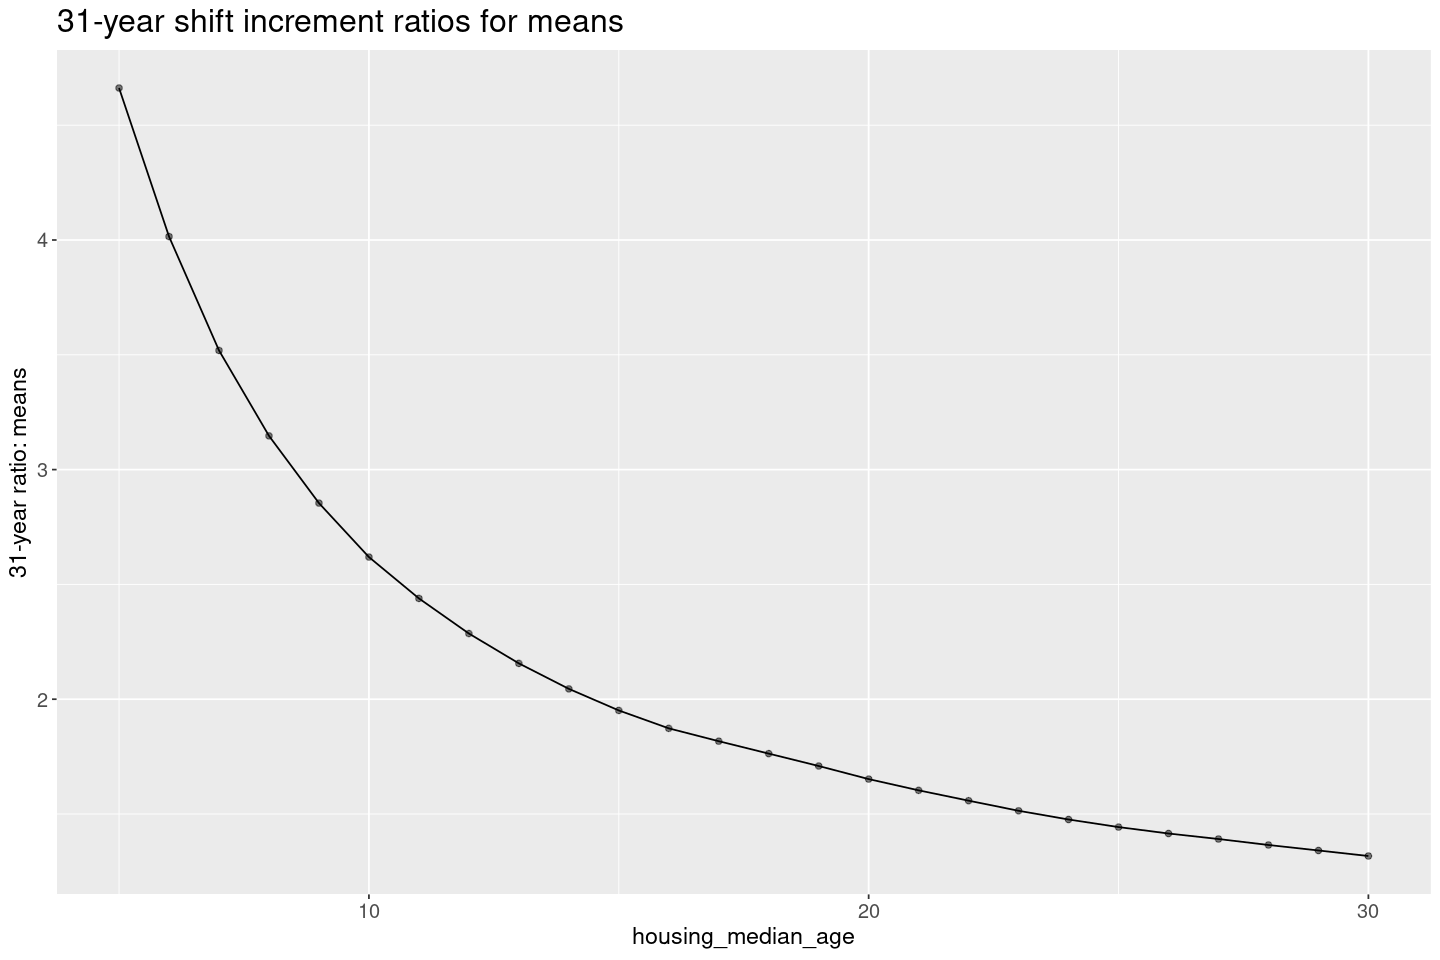

In [15]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_rat02, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("31-year ratio: means") +
  geom_line() +
  ggtitle("31-year shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [16]:
# There is very little variance in the counts for most of 
# the measurement points.  Even so, we get a better model
# below if we take into account these differences.

df_rat02$rcds


[1] 14819 15113 15346 15540 15640 15730 15834 15934 16051 16041 15873 15559
[13] 14970 14407 13973 13521 13176 12835 12537 12203 11823 11349 10814 10406
[25] 10018  9628

In [17]:
# Model for predicting mean_ratio at age = 52.  If we use
# rcds as a term in the model, the model wants both the 
# quadratic and cubic of rcds.  This will give us wild 
# prediction values at age 52, since 52 is so far beyond
# the range of the data from which our model is constructed.
# Using WLS works much better here than using polynomials

g03 <- lm(I(mean_ratio^0.19) ~ I(age^0.03) + I((age^0.03)^2), 
          data= df_rat02, weights=(df_rat02$rcds)^0.8)
ans <- summary(g03)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-0.0665 -0.0441 -0.0190  0.0435  0.1154 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)       50.799      1.092    46.5   <2e-16
I(age^0.03)      -87.116      2.021   -43.1   <2e-16
I((age^0.03)^2)   38.104      0.935    40.7   <2e-16

Residual standard error: 0.0564 on 23 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 5.12e+04 on 2 and 23 DF,  p-value: <2e-16


In [18]:
ncvTest(g03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.00015744, Df = 1, p = 0.99

In [19]:
residualPlots(g03, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(age^0.03)         -0.39             0.70
I((age^0.03)^2)     -0.52             0.61
Tukey test           0.51             0.61


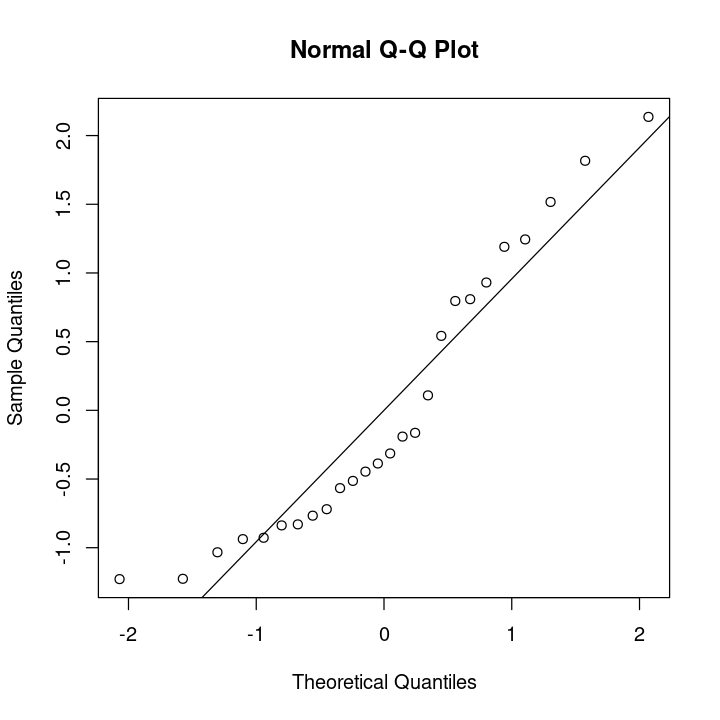

In [20]:
# The q-q plot below is not ideal.  The less ideal
# this plot is, the less we can trust our predictions.

options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g03, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [21]:
# Prediction for mean when age = 52.

newdat <- data.frame(age=52, rcds=1268)

ans <- predict.lm(g03, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.19); ans_transf
# 1.0973

# 1.0973 * 52 = 57.1 = 57


1 
1.0973

In [ ]:
### COMMENTS:

# The prediction looks plausible.  Our hypothesized distribution
# above had a mean of 58.4.  The pattern in the qqnorm plot
# means that we need to be careful about being over-confident in
# the g03 model prediction.


In [23]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(g03, newdata= newdat, interval="prediction",
                       level=0.95, weights=1268^0.8)
pred_ans_transf <- pred_ans^(1/0.19); pred_ans_transf


,fit,lwr,upr
1,1.0973,1.0545,1.1414


In [25]:
lwr <- round(pred_ans_transf[2] * 52, 1)
upr <- round(pred_ans_transf[3] * 52, 1)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, ", ", upr ,"]")
paste0(clause, print_ans)
# [54.8, 59.4]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [54.8, 59.4]"

### Plot the 31-year shift increment ratios for the medians

In [26]:
paste0("These are the 31-year shift increments for the medians: ")
names(median_ratios) <- as.character(5:30)
print(median_ratios)


[1] "These are the 31-year shift increments for the medians: "

    5     6     7     8     9    10    11    12    13    14    15    16    17 
4.800 4.167 3.571 3.250 2.889 2.600 2.455 2.333 2.154 2.071 2.000 1.875 1.824 
   18    19    20    21    22    23    24    25    26    27    28    29    30 
1.778 1.737 1.650 1.619 1.545 1.478 1.458 1.400 1.385 1.333 1.286 1.276 1.233 


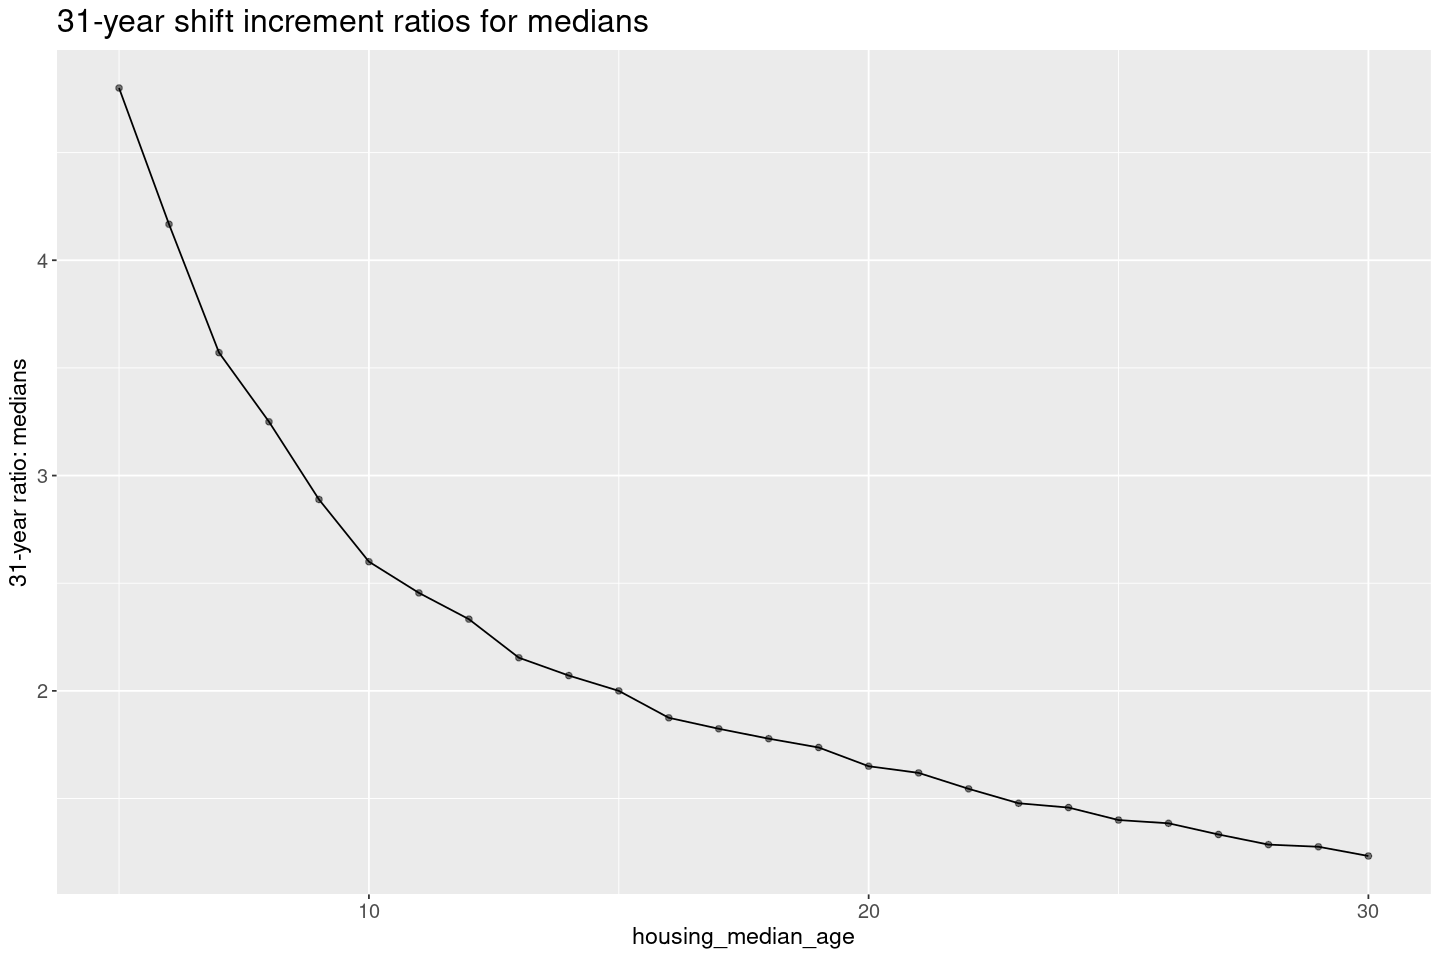

In [27]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_rat02, aes(age, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("31-year ratio: medians") +
  geom_line() +
  ggtitle("31-year shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p

# Compared to the previous curve based on means, the following
# curve for the medians is less smooth.  This has to do with
# the way the medians are computed.  It is also what likely makes
# it much more difficult to get good model predictions for the
# median.


In [28]:
# Model for predicting median_ratio at age = 52.

g04 <- lm(I(median_ratio^0.28) ~ I(age^0.03) + I((age^0.03)^2), 
          data= df_rat02, weights=(df_rat02$rcds)^0.5)
ans <- summary(g04)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.14370 -0.03870 -0.00706  0.04074  0.12442 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)        78.90       5.50    14.3  5.9e-13
I(age^0.03)      -135.71      10.19   -13.3  2.7e-12
I((age^0.03)^2)    59.08       4.71    12.5  9.2e-12

Residual standard error: 0.0681 on 23 degrees of freedom
Multiple R-squared:  0.998,	Adjusted R-squared:  0.998 
F-statistic: 5.69e+03 on 2 and 23 DF,  p-value: <2e-16


In [29]:
ncvTest(g04)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.040898, Df = 1, p = 0.84

In [30]:
residualPlots(g04, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(age^0.03)         -3.05           0.0059
I((age^0.03)^2)     -3.20           0.0041
Tukey test           0.01           0.9909


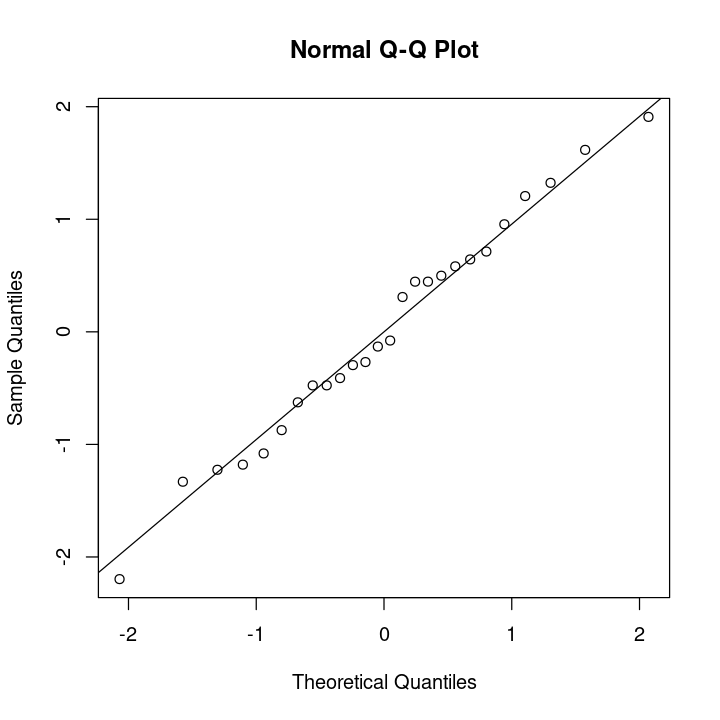

In [31]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g04, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [35]:
# Prediction for median when age = 52.

newdat <- data.frame(age=52, rcds=1268)

ans <- predict.lm(g04, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.28); ans_transf
# 0.9995

# 0.9995 * 52 = 52


1 
0.99949

In [38]:
### COMMENTS:

# The g04 prediction is not plausible.  While we expect the
# median to be less than the mean (predicted to be 57), we
# have a median of 58 for the hypothesized distribution, and
# so we do not expect the median to be as low as 52.


In [36]:
# Compute a 95% prediction interval for the median prediction.

pred_ans <- predict.lm(g04, newdata= newdat, interval="prediction",
                       level=0.95, weights=1268^0.5)
pred_ans_transf <- pred_ans^(1/0.28); pred_ans_transf


,fit,lwr,upr
1,0.99949,0.89654,1.1107


In [37]:
lwr <- round(pred_ans_transf[2] * 52, 1)
upr <- round(pred_ans_transf[3] * 52, 1)

clause <- "95% prediction interval for estimate of the median of the actual, unobserved values: "
print_ans <- paste0("[", lwr, ", ", upr ,"]")
paste0(clause, print_ans)
# [52, 57.8]


[1] "95% prediction interval for estimate of the median of the actual, unobserved values: [46.6, 57.8]"

### Get another prediction for the median, using more of the hypothesized distribution

In [129]:
# Get means and medians of the age values, looking out 
# 31 years.  Stop at age 35 instead of age 30.  Start
# at age 10 instead of age5.

mean_ratios <- median_ratios <- rep(NA, length(10:35))
means <- medians <- rep(NA, length(10:35))
rcd_count <- rep(NA, length(10:35))

span <- 31
for(cur_age in 10:35) {
    
    agevals <- rep(cur_age:(span + cur_age), 
                   as.numeric(all_counts[cur_age:(span + cur_age)]))
    counts <- as.numeric(all_counts[cur_age:(span + cur_age)])
    rcd_count[cur_age - 9] <- sum(counts)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 9] <- round(age_mean/cur_age, 3)
    means[cur_age - 9] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 9] <- round(age_median/cur_age, 3)
    medians[cur_age - 9] <- age_median
}

paste0("These are the 31-year shift increments for the medians: ")
names(median_ratios) <- as.character(10:35)
print(median_ratios)


df_rat02 <- rep(NA, 6*length(mean_ratios))
dim(df_rat02) <- c(length(mean_ratios), 6)
df_rat02 <- as.data.frame(df_rat02)
colnames(df_rat02) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_rat02$age <- 10:35
df_rat02$rcds <- rcd_count
df_rat02$mean_ratio <- mean_ratios
df_rat02$median_ratio <- median_ratios
df_rat02$mean <- means
df_rat02$median <- medians


[1] "These are the 31-year shift increments for the medians: "

   10    11    12    13    14    15    16    17    18    19    20    21    22 
2.600 2.455 2.333 2.154 2.071 2.000 1.875 1.824 1.778 1.737 1.650 1.619 1.545 
   23    24    25    26    27    28    29    30    31    32    33    34    35 
1.478 1.458 1.400 1.385 1.333 1.286 1.276 1.233 1.226 1.188 1.182 1.176 1.171 


In [181]:
# Model for predicting median_ratio at age = 52.

g05 <- lm(I(median_ratio^1) ~ I(age^0.03) + I((age^0.03)^2), 
          data= df_rat02, weights=(df_rat02$rcds)^0.001)
ans <- summary(g05)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.03874 -0.01360  0.00014  0.00994  0.03885 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)        497.4       35.7    13.9  1.0e-12
I(age^0.03)       -872.3       65.3   -13.4  2.5e-12
I((age^0.03)^2)    383.2       29.8    12.8  5.7e-12

Residual standard error: 0.0204 on 23 degrees of freedom
Multiple R-squared:  0.998,	Adjusted R-squared:  0.998 
F-statistic: 5.46e+03 on 2 and 23 DF,  p-value: <2e-16


In [182]:
ncvTest(g05)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.39838, Df = 1, p = 0.528

In [183]:
residualPlots(g05, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(age^0.03)          3.17           0.0045
I((age^0.03)^2)      2.25           0.0345
Tukey test           0.01           0.9885


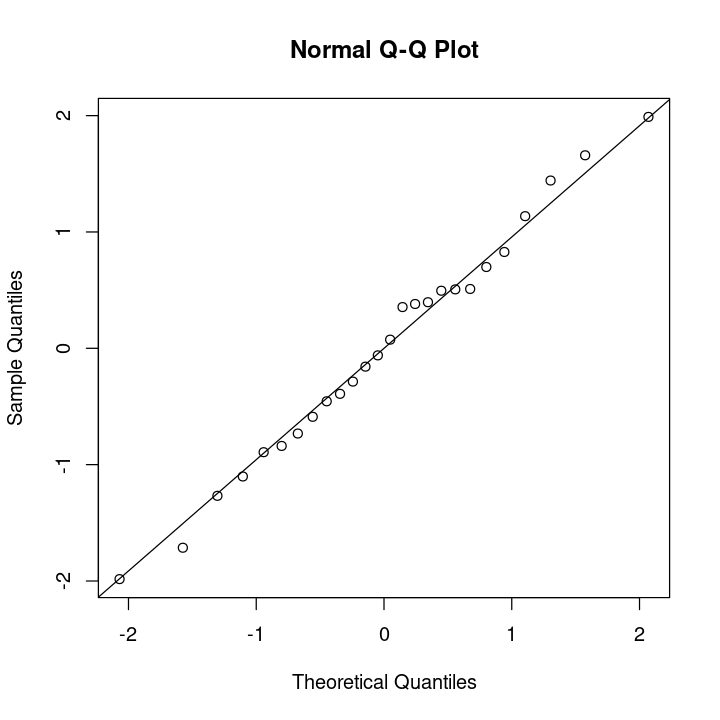

In [184]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g05, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [185]:
# Prediction for median when age = 52.

newdat <- data.frame(age=52, rcds=1268)

ans <- predict.lm(g05, newdata= newdat, type= "response")
ans
# 0.9482

# 0.9482 * 52 < 52


1 
0.94818

In [ ]:
### COMMENTS:

# Even though the model diagnostics look good, the g04 and
# g05 models are not able to give us plausible predictions
# for the median of the actual, unobserved ages >= 52.

# A good prediction for the median would lend further support
# to my prediction for the mean.  Unfortunately, this 
# additional support is not provided by the above models.


## Final Comments for Section 1

For the imputation process that follows, having a good prediction for the mean is important.  From the above we can be fairly confident that the mean of the true, unobserved district ages is <= 60 and the median is <= 59.  We can be fairly confident that the median will be less than the mean.  The mean is likely to be between 55 and 59; our current working prediction is that the mean is around **57** or **58**.  (I will use 57 below.)  The median is likely to be between 53 and 58.  We do not have a good prediction for the median by way of modeling the data.

The sharp drop-off in counts is what pulls both the mean and median in closer to the cap of 52.  Since I would not be surprised if the counts dropped off even more sharply than what is shown in our hypothesized distribution, I  use 57 rather than 58 as our prediction for the mean when adjusting the Gibbs sampler output below.



                                      * * * * *

# Section 2: Impute values for censored ages

This section complements the material in Section 2 of Part01.



In [ ]:
# Continue to use dat from Section 1 above.  6.15% of the
# records in dat have a censored housing median age.


In [200]:
colnames(dat)
summary(dat$housing_median_age)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    28.6    37.0    52.0 

In [201]:
# This is the model from Section 2, Part01 that we want 
# to use for imputing age values.

a03 <- lm(housing_median_age ~ 

            I(long_transf^-1) +
            I(long_transf^-1.5) +
          
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
          
            I(households^0.55) +
            I(households^1.1) +
          
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
          
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
          data= dat, weights= dat$households^0.55)

## REMINDER: dat has censored housing_median_age values.

a03.summary <- summary(a03); 
a03.summary[[1]] <- ""; a03.summary



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-229.00  -36.97    1.64   35.26  239.57 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)
(Intercept)                -8.92e+04   5.71e+03   -15.6   <2e-16
I(long_transf^-1)           4.43e+02   1.78e+01    24.9   <2e-16
I(long_transf^-1.5)        -4.93e+02   2.13e+01   -23.1   <2e-16
latitude                    9.73e+03   6.28e+02    15.5   <2e-16
I(latitude^2)              -3.97e+02   2.59e+01   -15.3   <2e-16
I(latitude^3)               7.19e+00   4.73e-01    15.2   <2e-16
I(latitude^4)              -4.88e-02   3.23e-03   -15.1   <2e-16
I(households^0.55)         -6.26e-01   1.96e-02   -31.9   <2e-16
I(households^1.1)           2.73e-03   2.15e-04    12.7   <2e-16
I(median_house_value^0.48)  2.69e-01   1.05e-02    25.7   <2e-16
I(median_house_value^0.24) -1.04e+01   3.97e-01   -26.2   <2e-16
I(HHdens_ln^1.35)          -9.87e-01   7.66e-02   -12.9   <2e-16
I(HHdens_ln^2.7)           

In [202]:
ncvTest(a03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.13688, Df = 1, p = 0.711

In [203]:
residualPlots(a03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(long_transf^-1)              -6.43          1.3e-10
I(long_transf^-1.5)            -6.53          6.7e-11
latitude                      -10.83          < 2e-16
I(latitude^2)                  -9.83          < 2e-16
I(latitude^3)                  -8.94          < 2e-16
I(latitude^4)                  -8.36          < 2e-16
I(households^0.55)             -8.07          7.2e-16
I(households^1.1)               5.08          3.8e-07
I(median_house_value^0.48)     -5.82          5.9e-09
I(median_house_value^0.24)     -7.61          2.8e-14
I(HHdens_ln^1.35)               7.57          3.8e-14
I(HHdens_ln^2.7)                5.70          1.2e-08
Tukey test                      0.05             0.96


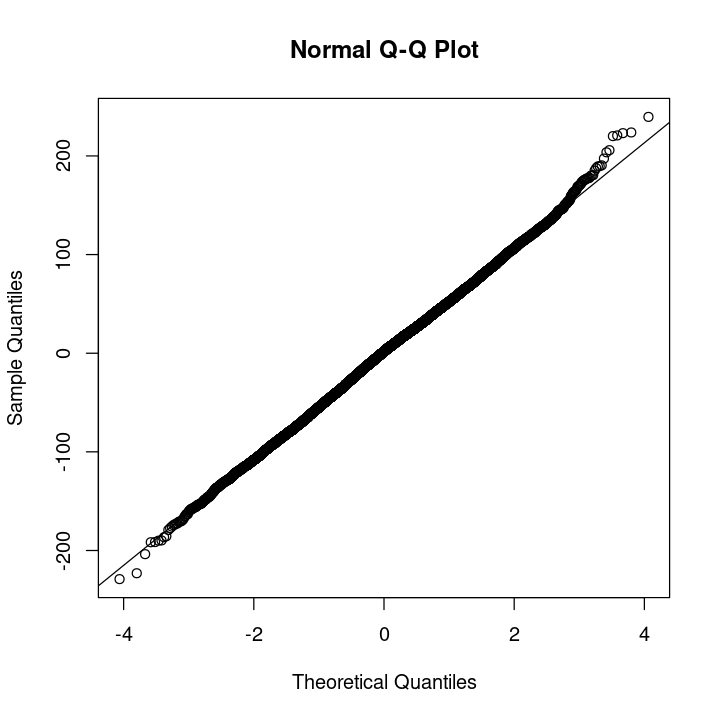

In [204]:
options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a03, type= "pearson"))
qqline(residuals(a03, type= "pearson"))


In [12]:
# The value we assign to the upper limit is important.  The
# aim is to have an imputation range that captures most of
# the ages we would expect to find.  If we expand the range 
# too much, the quality of the imputed values (measured in
# terms of how close, on average, they are to the actual
# values) will decrease.  The mean of the predictions from
# the Gibbs sampler will be about halfway between the lower limit
# and the upper limit.  With 78 as the upper limit, the mean
# should be around age 65.

C <- 52
censored <- dat$housing_median_age >= C

# Create an upper limit.
C_upper <- 78

# Create some crude starting values for our imputed ages.
n.censored <- sum(censored)
z <- ifelse(censored, NA, dat$housing_median_age)
z[censored] <- runif(n.censored, C, C_upper)


In [206]:
length(censored)
n.censored


[1] 20603

[1] 1268

In [10]:
# Function to draw from a constrained normal distribution.

rnorm.trunc <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need mu to be at least the value of C in
    # order to prevent a return of Inf values.
    mu02 <- ifelse(mu < C, C, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [12]:
# Create matrix X for the terms in our model.

X <- dat

X$long1 <- (X$long_transf)^-1
X$long2 <- (X$long_transf)^-1.5

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$hh1 <- (X$households)^0.55
X$hh2 <- (X$households)^1.10

X$median_hhval_1 <- (X$median_house_value)^0.24
X$median_hhval_2 <- (X$median_house_value)^0.48

X$HHdens_ln1 <- (X$HHdens_ln)^1.35
X$HHdens_ln2 <- (X$HHdens_ln)^2.7


X <- X[, c("long1","long2","latitude","lat2","lat3","lat4",
           "hh1","hh2","median_hhval_1","median_hhval_2",
           "HHdens_ln1","HHdens_ln2")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 20603    13

[1] "intercept"      "long1"          "long2"          "latitude"      
 [5] "lat2"           "lat3"           "lat4"           "hh1"           
 [9] "hh2"            "median_hhval_1" "median_hhval_2" "HHdens_ln1"    
[13] "HHdens_ln2"

In [ ]:
# The Gibbs Sampler.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 14 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        a03.1 <- lm(z ~ 
                    
            I(long_transf^-1) +
            I(long_transf^-1.5) +
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(households^0.55) +
            I(households^1.1) +
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
            data= dat, weights= dat$households^0.55)
        
        sim.1 <- sim(a03.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.6 mins (for 2K iterations)


In [ ]:
# We check for convergence as follows:

sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [ ]:
str(sims.bugs)

# Output for this cell has been removed because it
# interferes with the output of cells further downstream.


In [ ]:
save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age.RData")


In [4]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age.RData")


In [5]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1282

In [6]:
# Check that the means and stddevs for the parameters and 
# imputed values does not include the burn-in values.

sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [7]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 64.60 64.73 64.89 64.76 64.91 65.03

[1] 7.47 7.60 7.42 7.47 7.39 7.48

In [8]:
summary(z_means)
summary(z_sds)

# Notice that the minimum stddev is 7.3 years. and
# that the average stddev is close to 7.5 years.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   64.4    64.7    64.8    64.8    64.9    65.2 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.31    7.44    7.48    7.48    7.51    7.64 

In [ ]:
### COMMENTS:

# From the work in Section 1 above, we expect the mean for the
# censored records to be about 57, not 65.  I can adjust for this
# by subtracting 8 from each prediction.  


In [13]:
# Get some predictions, using rnorm.trunc.

set.seed(1931)
z_preds <- round(rnorm.trunc(n.censored, z_means, z_sds, lo=C, hi=C_upper), 1)
summary(z_preds)

# Notice that the mean and median of our predictions are around 65.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.1    60.5    65.0    65.0    69.5    78.0 

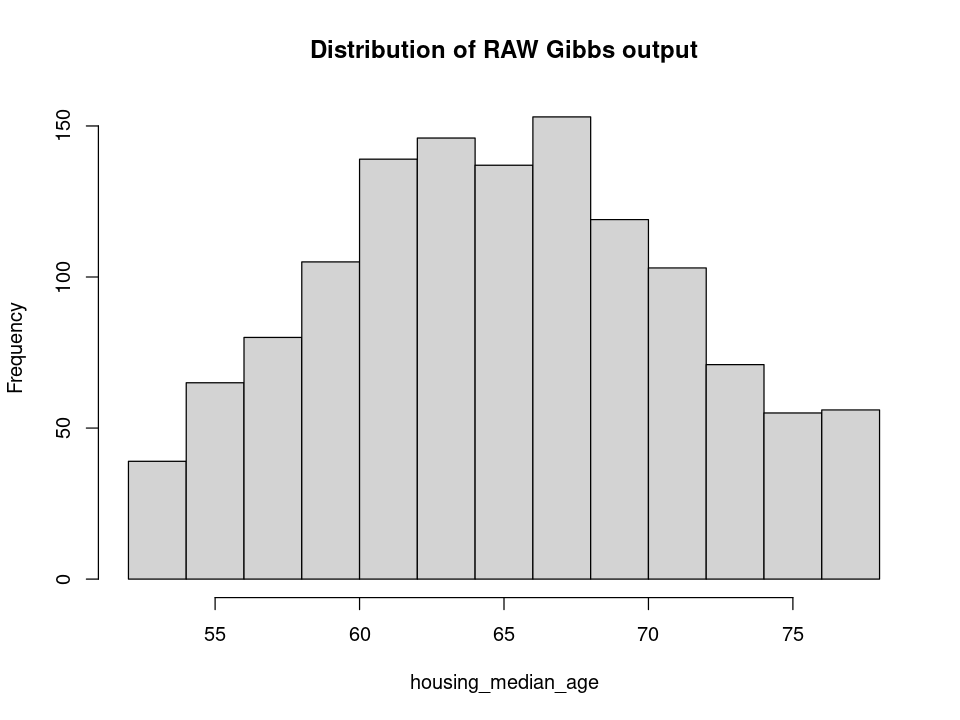

In [234]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=14, main="Distribution of RAW Gibbs output",
     xlab="housing_median_age")


In [ ]:
### COMMENTS:

# The above shape is not what we want for our imputed values
# (assuming we want our imputed values to have a distribution
# like the distribution we would expect the true, unobserved
# values to have). 


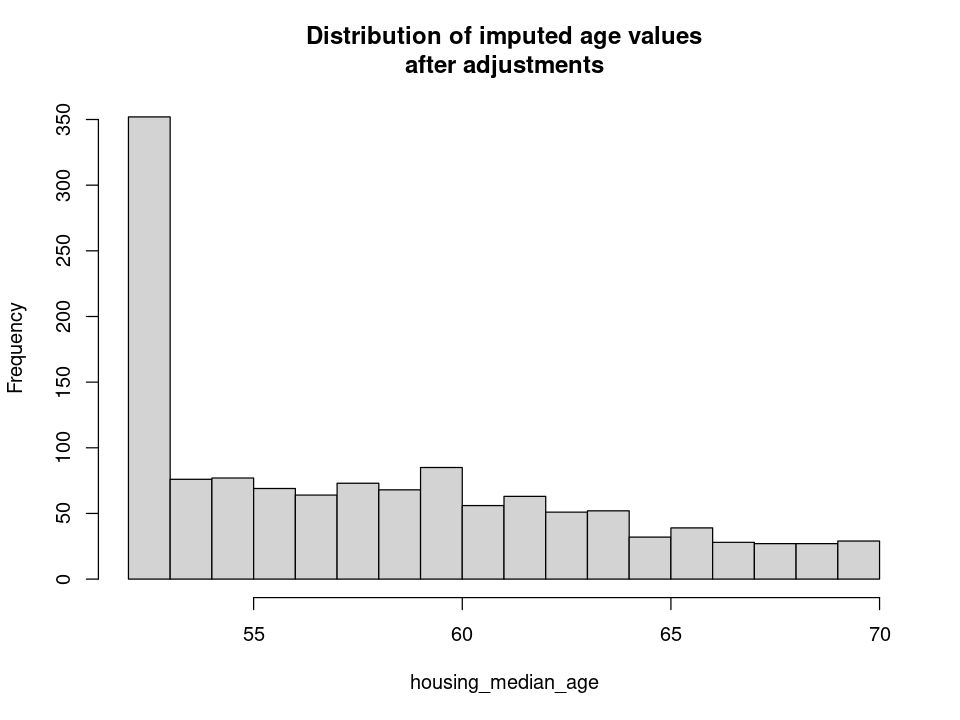

In [14]:
# Adjust the predictions based on what we learned in 
# Section 1.  We want the mean of our imputed values
# to be about 57.

z_preds <- z_preds - 8
preds_adj <- ifelse(z_preds < 52, 52, z_preds)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=14, main="Distribution of imputed age values
after adjustments",
     xlab="housing_median_age")


In [15]:
summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    52.5    57.0    57.8    61.5    70.0 

In [ ]:
### COMMENTS:

# While the mean and median are now ABOUT where we expect them to
# be, we do not expect there to be a sudden drop in the number
# of districts as housing_median_age increases from 52 to 
# 53; we expect the drop, if there is one, to be more gradual; 

# We can fix this by adjusting z_means prior to 
# calling rnorm.trunc.


In [16]:
# The following provides us with a start.  The subtrahend
# used here will need to be adjusted once we see the truncated
# output from rnorm.trunc.

(z_means_bar <- mean(z_means))
z_means_adj <- z_means - (z_means_bar - 57)
mean(z_means_adj)


[1] 64.808

[1] 57

In [17]:
# Get new predictions.  I have lowered the upper limit from
# 78 to 75.  This will help to bring the mean down.

set.seed(1933)
z_preds <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=75), 2)
summary(z_preds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    55.7    59.1    60.0    63.4    75.0 

In [18]:
# Make another correction.  (Even if I continue to lower
# the subtrahend, I will not be able to push the mean
# lower than it currently is.)

z_means_adj <- z_means - (z_means_bar - 52)
mean(z_means_adj)

set.seed(1933)
z_preds <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=75), 2)
summary(z_preds)
# The mean is now at about 58 and the median at 57.


[1] 52

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    54.3    56.9    57.9    60.6    74.9 

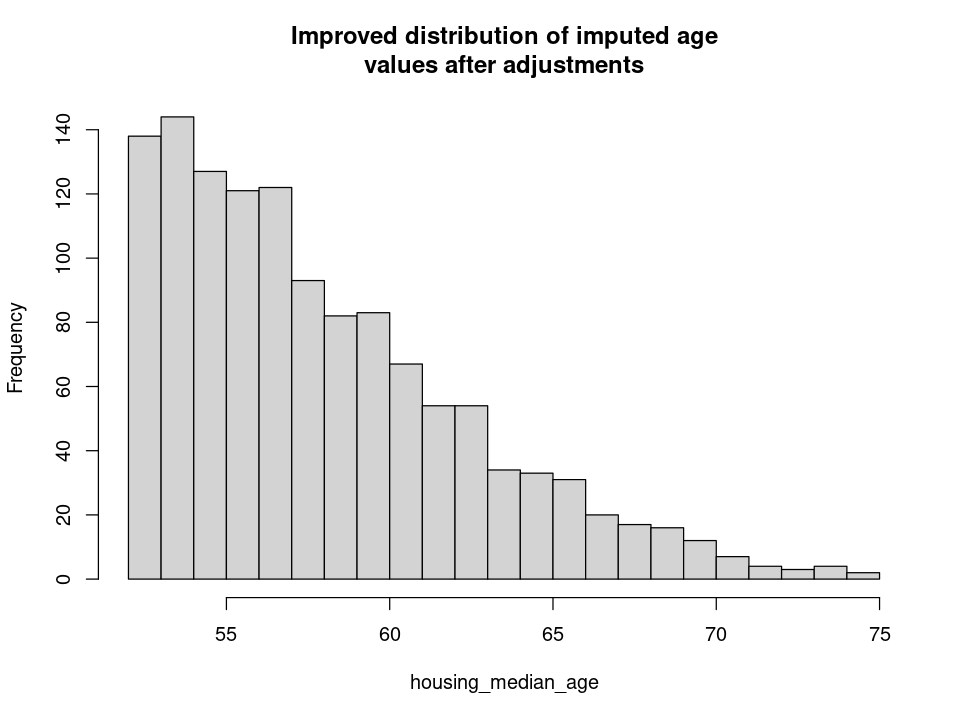

In [227]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, 
     main="Improved distribution of imputed age
values after adjustments", xlab="housing_median_age")


In [ ]:
### COMMENT:

# The shape of the above distribution is far more plausible
# than the previous distribution of predictions, which had
# around 30% of the predictions at age 52.  Also, we
# now have a mean of 58 for the imputed values rather than
# 65.  

# There is a trade-off with respect to setting the upper
# limit.  If I expand the range of ages in which my 
# predictions can lie beyond a certain point, the less 
# accurate the predictions will be, on average.  For the 
# current set of predictions, I now have an upper limit for
# age of 75 years.  There are likely to be a few districts 
# with an age > 75, but we know that the vast majority of 
# districts will have an age that lies in the range of 52-75.
# One might argue that I should be even more conservative with
# the upper limit, but the more I lower it, the closer the shape
# of the distribution comes to being uniform.  For present 
# purposes, we do not want such a shape.  

# When we compare the performance of different models, I will
# treat the imputed values as if they are true, observed values.
# Thus, I want the shape of the above distribution to be like the 
# shape we would expect to see from the true values.


In [228]:
# Assign imputed values.

newdat <- dat
newdat$housing_median_age[censored] <- z_preds


In [229]:
summary(newdat$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    74.9 

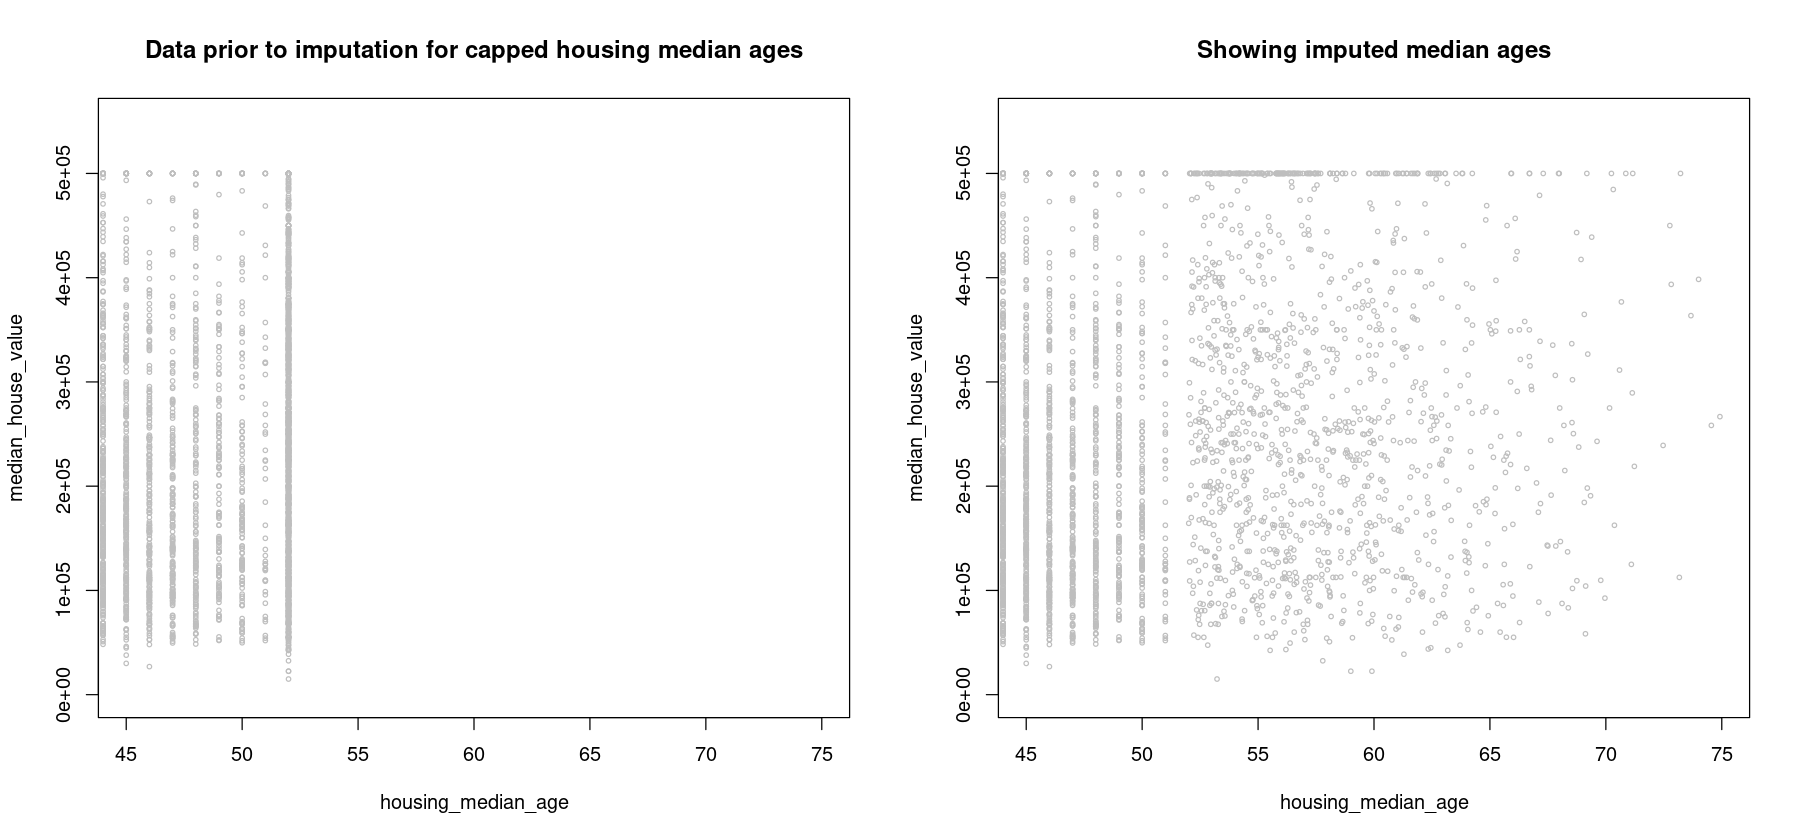

In [230]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$housing_median_age, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Data prior to imputation for capped housing median ages")


# plot the newly predicted values
plot(newdat$housing_median_age, newdat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Showing imputed median ages")


### Save to disk

In [231]:
# Saving imputed values for housing_median_age to housing_cleaned_v03.csv.

write.csv(newdat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
          row.names=TRUE)


In [232]:
rm(newdat)


In [3]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat); colnames(dat)


[1] 20603    15

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

## Re-assess Section 1 predictions for mean and median

With the additional data, we can roll a 15-year window out to age 52 if we like.  But if we stop at age 45, even our last data point will be based mostly on observed data, and not the imputed values.  This will allow me to make a prediction for age 52 that is still mostly based on the observed data.  We can then see if the prediction agrees with our current prediction of the mean at 57.  If there is agreement, we can conclude that the imputed values are consistent with the observed data.  There are very few imputed values > age 67, so a 15-year window captures most of the data for an age-52 prediction.

Note that a 15-year window is too small for around 40\% of our age measurement points used in the models that follow.  Ideally we would like a 1.6X window; this translates to an 18-year window for age 30 and a 12-year window for age 20.  The 15-year window is ideal for age 25.  Previously we had used a 31-year window, which was far too large for *all* of our modeling data.


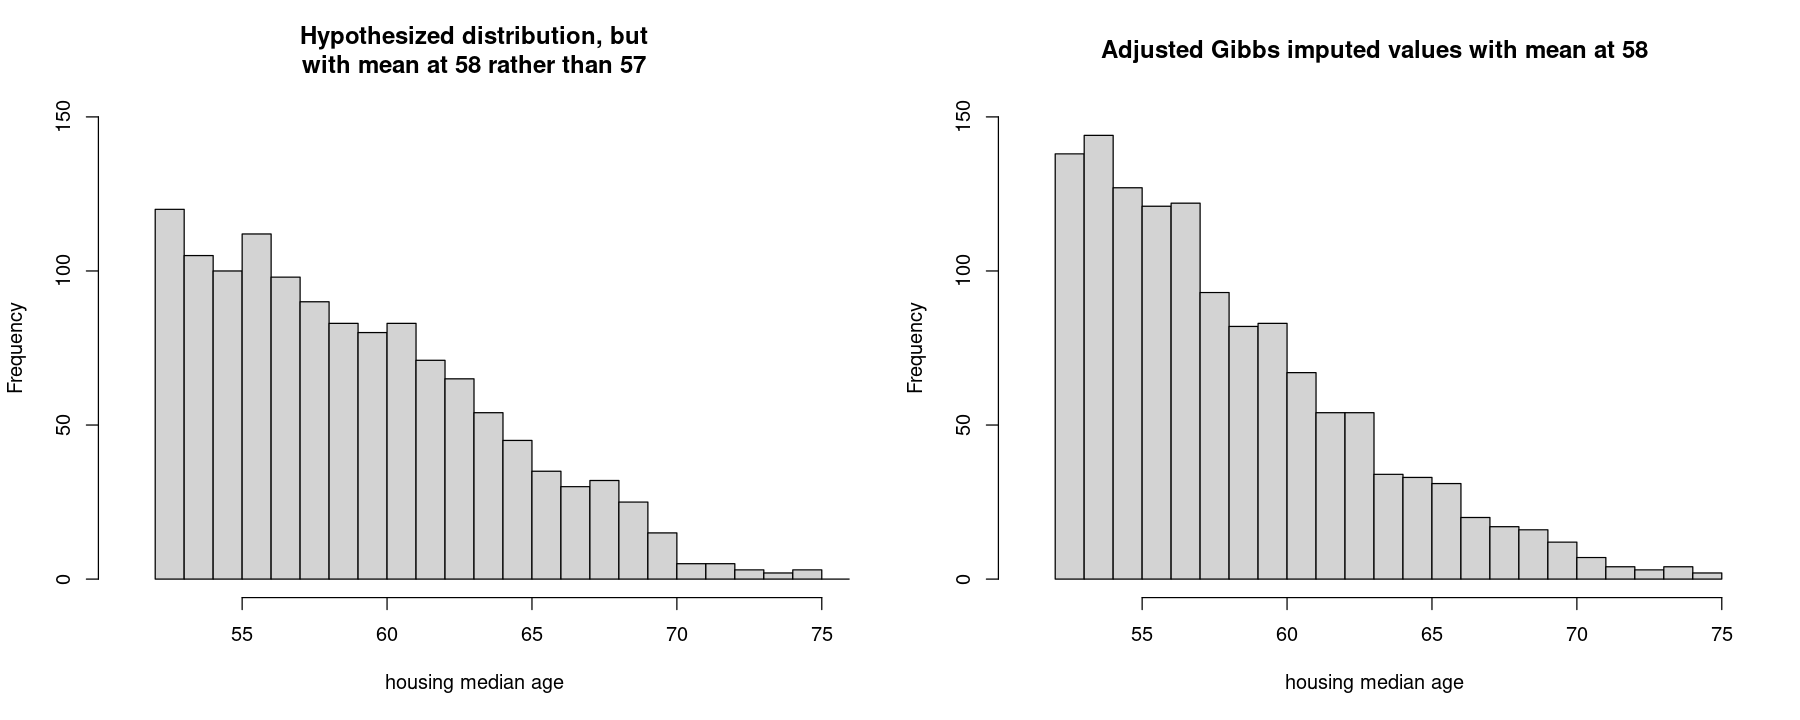

In [34]:
# Compare the hypothesized distribution with the current distribution
# of imputed values.

mydist <- c(120, 105, 100, 112, 98, 90, 83, 80, 83, 71,
            65, 54, 45, 35, 30, 32, 25, 15, 5, 5, 3, 2, 3,
            0, 2, 2, 1, 1, 0, 0, 1)
# We need to jitter the ages so the graph below on the left 
# looks like the panel on the right.  (The automatic binning
# does not do what we expect unless we do this.)
hyp_dist <- rep(52:82, mydist) + 0.2


options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(hyp_dist, breaks=24, main="Hypothesized distribution, but
with mean at 58 rather than 57", xlim=c(51, 75),
     ylim=c(0, 150), xlab="housing median age")

# Right panel.
hist(z_preds, breaks=20, main="Adjusted Gibbs imputed values with mean at 58",
     ylim=c(0, 150), xlim=c(51, 75), xlab="housing median age")


In [35]:
# Get means and medians of the age values, 
# looking out 15 years.  A span of 15 means that
# each window includes 16 years of data.

mean_ratios <- median_ratios <- rep(NA, length(2:52))
means <- medians <- rep(NA, length(2:52))
rcd_count <- rep(NA, length(2:52))

span <- 15
for(cur_age in 2:52) {
    
    agevals <- as.numeric(dat[which((dat$housing_median_age >= cur_age) &
                        (dat$housing_median_age <= round(span + cur_age))),
                  c("housing_median_age")])
    counts <- as.numeric(table(as.factor(agevals)))
    rcd_count[cur_age - 1] <- sum(counts)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 1] <- round(age_mean/cur_age, 3)
    means[cur_age - 1] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 1] <- round(age_median/cur_age, 3)
    medians[cur_age - 1] <- age_median
}

paste0("15-year shift increments for the means: ")
names(mean_ratios) <- as.character(2:52)
print(mean_ratios)


df_rat03 <- rep(NA, 6*length(mean_ratios))
dim(df_rat03) <- c(length(mean_ratios), 6)
df_rat03 <- as.data.frame(df_rat03)
colnames(df_rat03) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_rat03$age <- 2:52
df_rat03$rcds <- rcd_count
df_rat03$mean_ratio <- mean_ratios
df_rat03$median_ratio <- median_ratios
df_rat03$mean <- means
df_rat03$median <- medians


[1] "15-year shift increments for the means: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
6.085 4.305 3.389 2.873 2.535 2.266 2.072 1.926 1.816 1.734 1.652 1.579 1.519 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.475 1.441 1.432 1.425 1.415 1.407 1.397 1.373 1.344 1.319 1.295 1.275 1.263 
   28    29    30    31    32    33    34    35    36    37    38    39    40 
1.247 1.233 1.216 1.200 1.183 1.170 1.158 1.150 1.145 1.143 1.142 1.138 1.135 
   41    42    43    44    45    46    47    48    49    50    51    52 
1.129 1.125 1.124 1.124 1.128 1.130 1.130 1.129 1.126 1.120 1.116 1.102 


In [36]:
# Compute the amount of observed data for the interval [45, 60]; 
# this is our last data point used in the model below.

total <- nrow(dat[which((dat$housing_median_age >= 45) & (dat$housing_median_age <= 60)),])
observed <- nrow(dat[which((dat$housing_median_age >= 45) & (dat$housing_median_age <= 51)),])
(percent_observed <- 100* round(observed/total, 3))
paste0("The percent of observed data remaining at age 45, for the 15-year window is: ", 
       as.character(percent_observed))


[1] 57.4

[1] "The percent of observed data remaining at age 45, for the 15-year window is: 57.4"

In [37]:
# Compute the amount of observed data for the interval [40, 55].
# Recall that the interval from [36, 51] has 100% observed data.

total <- nrow(dat[which((dat$housing_median_age >= 40) & (dat$housing_median_age <= 55)),])
observed <- nrow(dat[which((dat$housing_median_age >= 40) & (dat$housing_median_age <= 51)),])
(percent_observed <- 100* round(observed/total, 3))
paste0("The percent of observed data remaining at age 40, for the 15-year window is: ", 
       as.character(percent_observed))


[1] 87.7

[1] "The percent of observed data remaining at age 40, for the 15-year window is: 87.7"

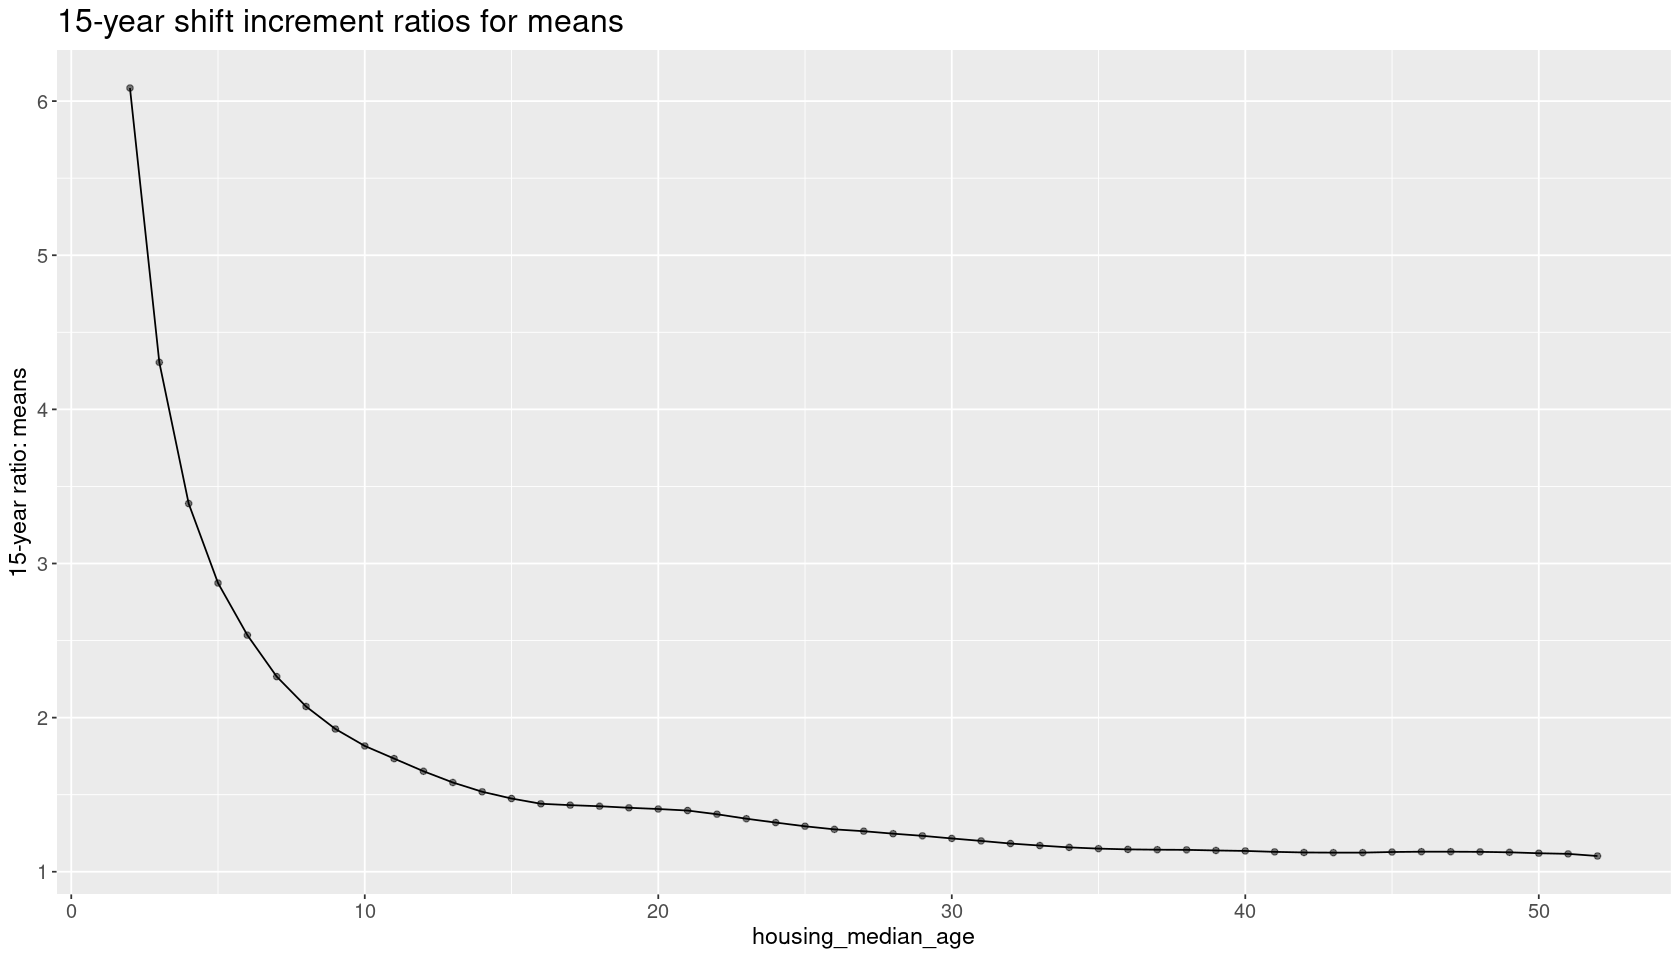

In [38]:
options(repr.plot.width= 14, repr.plot.height= 8)

p <- ggplot(df_rat03, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("15-year ratio: means") +
  geom_line() +
  ggtitle("15-year shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [39]:
# The stddev has increased substantially.

round(sd(df_rat03$rcds), 1)


[1] 2604.1

In [40]:
df_rat04 <- df_rat03[which(df_rat03$age <= 45),]
dim(df_rat04)


[1] 44  6

In [41]:
tail(df_rat04$rcds)


[1] 3312 3129 2956 2681 2410 2138

In [42]:
# Model for predicting mean_ratio at age = 52.

p02 <- lm(I(mean_ratio^0.47) ~ I(age^-0.247) + I((age^-0.247)^2) , 
          data= df_rat04)
ans <- summary(p02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
     Min       1Q   Median       3Q      Max 
-0.01679 -0.00677 -0.00256  0.00660  0.02277 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)          1.455      0.035    41.6   <2e-16
I(age^-0.247)       -2.818      0.127   -22.2   <2e-16
I((age^-0.247)^2)    4.595      0.110    41.7   <2e-16

Residual standard error: 0.0101 on 41 degrees of freedom
Multiple R-squared:  0.999,	Adjusted R-squared:  0.999 
F-statistic: 1.48e+04 on 2 and 41 DF,  p-value: <2e-16


In [43]:
ncvTest(p02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.21575, Df = 1, p = 0.642

In [44]:
residualPlots(p02, plot=FALSE)


                  Test stat Pr(>|Test stat|)
I(age^-0.247)          0.19             0.85
I((age^-0.247)^2)      0.15             0.88
Tukey test             0.00             1.00


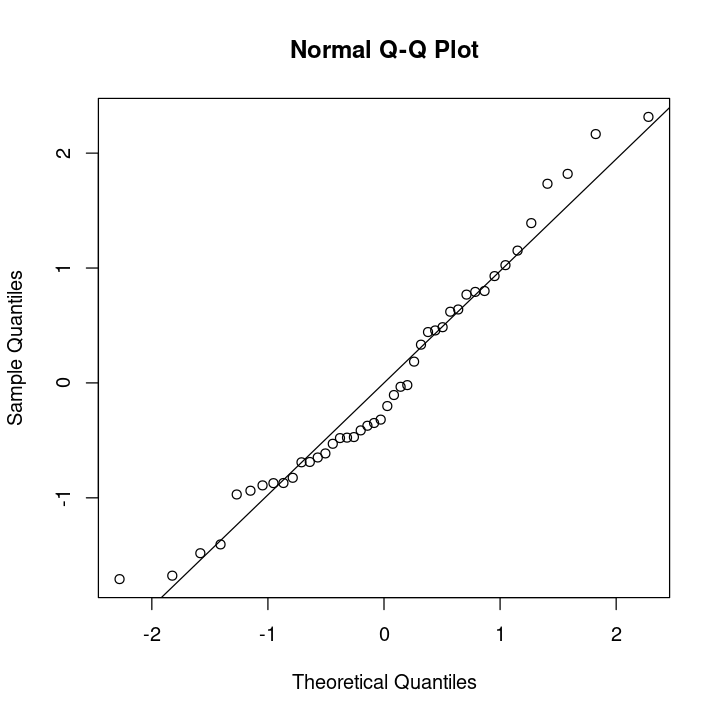

In [45]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(p02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [46]:
# Prediction for mean when age = 52.

newdat <- df_rat04[1, ]
newdat[1, ] <- c(52, rep(NA, 5))

ans <- predict.lm(p02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.47); ans_transf
# 1.099

# 1.099 * 52 = 57.1 


1 
1.0988

In [47]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(p02, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.47); pred_ans_transf


,fit,lwr,upr
1,1.0988,1.0515,1.1472


In [48]:
lwr <- round(pred_ans_transf[2] * 52, 1)
upr <- round(pred_ans_transf[3] * 52, 1)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, ", ", upr ,"]")
paste0(clause, print_ans)
# [54.7, 59.7]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [54.7, 59.7]"

In [ ]:
### COMMENTS:

# At age 45 the 15-year window takes us out to age 60.  The
# shift-increment ratio for the mean at age 45 is based on
# 57% observed data and 43% imputed values.  But for the 
# interval [40, 55], the computed shift-increment is based
# on 88% observed and only 12% imputed.  In other words, the
# p02 model is not overly influenced by the imputed values.

# Using the predicted ratio of 1.099, the predicted mean at 
# age 52 is 57.1.  With the current set of imputed values, 
# the "actual" ratio at age 52 is 1.102.  1.102 * 52 = 57.3.  
# For ALL 1268 imputed values, the mean is at 57.9.  

# The actual mean is larger than 57.3 because the 1.102 shift
# increment is only for the interval [52, 67] and imputed 
# values go out to age 75.

# Unless we find something terribly out of line with the 
# prediction for the median that follows, I am satisfied that
# the current set of imputed values are consistent with the
# data.


In [49]:
paste0("15-year shift increments for the medians: ")
names(median_ratios) <- as.character(2:52)
print(median_ratios)


[1] "15-year shift increments for the medians: "

    2     3     4     5     6     7     8     9    10    11    12    13    14 
7.000 4.667 3.750 3.200 2.667 2.286 2.125 1.889 1.800 1.727 1.583 1.538 1.500 
   15    16    17    18    19    20    21    22    23    24    25    26    27 
1.467 1.438 1.471 1.444 1.421 1.400 1.429 1.409 1.391 1.333 1.320 1.308 1.259 
   28    29    30    31    32    33    34    35    36    37    38    39    40 
1.250 1.207 1.200 1.161 1.156 1.121 1.118 1.114 1.139 1.135 1.132 1.128 1.100 
   41    42    43    44    45    46    47    48    49    50    51    52 
1.098 1.095 1.093 1.091 1.111 1.134 1.132 1.127 1.121 1.113 1.104 1.087 


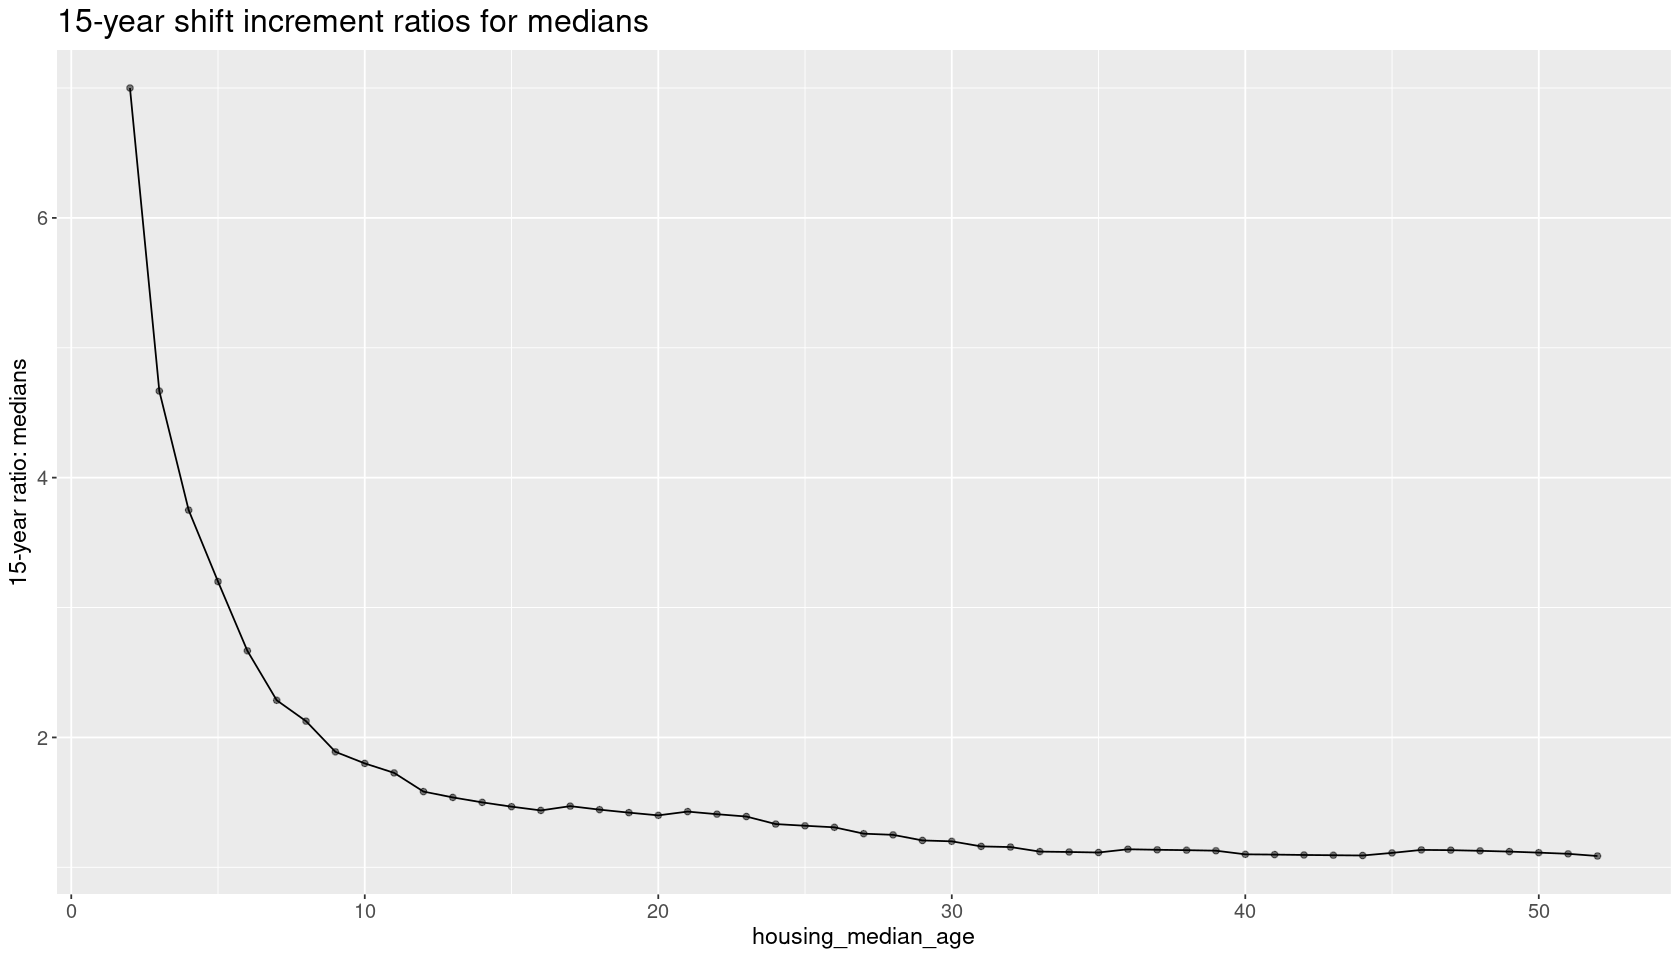

In [50]:
options(repr.plot.width= 14, repr.plot.height= 8)

p <- ggplot(df_rat03, aes(age, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("15-year ratio: medians") +
  geom_line() +
  ggtitle("15-year shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [51]:
# Model for predicting median_ratio at age = 52.

p03 <- lm(I(median_ratio^0.47) ~ I(age^-0.247) + I((age^-0.247)^2) , 
          data= df_rat04)
ans <- summary(p03)
ans[[1]] <- ""; ans



Call:
""

Residuals:
    Min      1Q  Median      3Q     Max 
-0.0388 -0.0140 -0.0039  0.0149  0.0436 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)         1.6280     0.0763    21.3  < 2e-16
I(age^-0.247)      -3.6528     0.2768   -13.2  2.4e-16
I((age^-0.247)^2)   5.5597     0.2403    23.1  < 2e-16

Residual standard error: 0.0219 on 41 degrees of freedom
Multiple R-squared:  0.995,	Adjusted R-squared:  0.994 
F-statistic: 3.89e+03 on 2 and 41 DF,  p-value: <2e-16


In [52]:
ncvTest(p03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.12426, Df = 1, p = 0.724

In [53]:
residualPlots(p03, plot=FALSE)


                  Test stat Pr(>|Test stat|)
I(age^-0.247)          0.84             0.41
I((age^-0.247)^2)      0.64             0.53
Tukey test             0.46             0.65


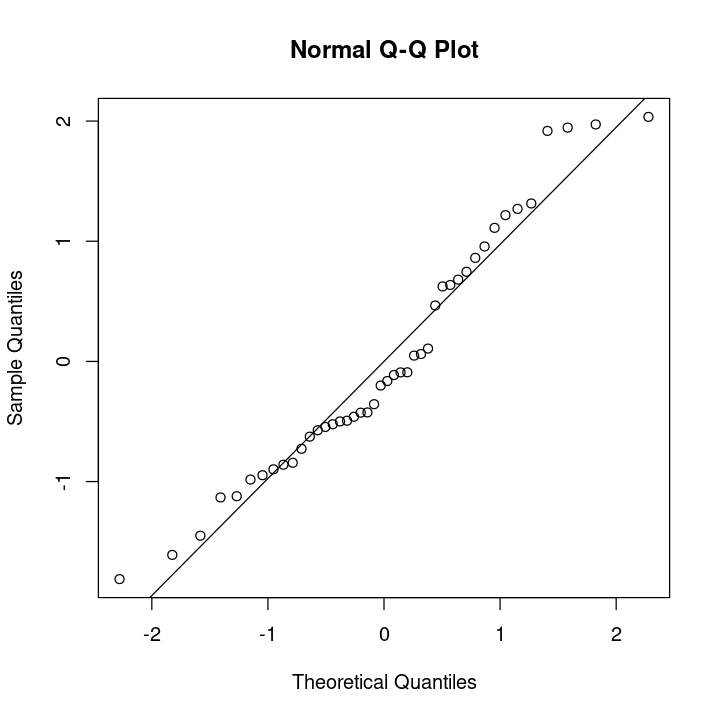

In [54]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(p03, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [55]:
# Prediction for median when age = 52.

newdat <- df_rat04[1, ]
newdat[1, ] <- c(52, rep(NA, 5))

ans <- predict.lm(p03, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.47); ans_transf
# 1.089

# 1.089 * 52 = 56.6


1 
1.0892

In [56]:
# What percent of the 1268 imputed values lie in the
# range, [68, 75]?  If 3% or more records are in this
# region, this will increase the median from what the
# model predicts.

total <- 1268
other <- nrow(dat[which((dat$housing_median_age >= 68) & (dat$housing_median_age <= 75)),])
(percent_other <- 100* round(other/total, 3))
paste0("The percent of imputed values not in [52, 67]: ", 
       as.character(percent_other))


[1] 3.8

[1] "The percent of imputed values not in [52, 67]: 3.8"

In [57]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(p03, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.47); pred_ans_transf


,fit,lwr,upr
1,1.0892,0.98812,1.1956


In [58]:
lwr <- round(pred_ans_transf[2] * 52, 1)
upr <- round(pred_ans_transf[3] * 52, 1)

clause <- "95% prediction interval for estimate of the median of the actual, unobserved values: "
print_ans <- paste0("[", lwr, ", ", upr ,"]")
paste0(clause, print_ans)
# [52, 62.2]


[1] "95% prediction interval for estimate of the median of the actual, unobserved values: [51.4, 62.2]"

In [ ]:
### COMMENTS:

# The predicted median at age 52 is 56.6.  This is very much
# what we would expect with a predicted mean of 57.1.  With
# the current set of imputed values, the "actual" ratio at
# age 52 is 1.087.  1.087 * 52 = 56.5.  For ALL 1268 imputed
# values, the median is at 56.8.  The slight increase is 
# expected since 3.8% of the 1268 imputed values are not in
# the 15-year shift-increment window for age 52.

# In sum, models p02 and p03 provide good evidence for thinking
# that the current set of imputed values are consistent with
# the observed data.  In particular, it looks like the SHAPE of
# the distribution of imputed values is what it ought to be.
# This is critical because the shape we are settling on is not
# the one provided directly from the Gibbs sampler.


[1] 1268


 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71 
 65 149 133 117 135 104  84  72  89  56  56  44  35  26  29  17  16  18   7   7 
 72  73  74  75 
  1   4   2   2 

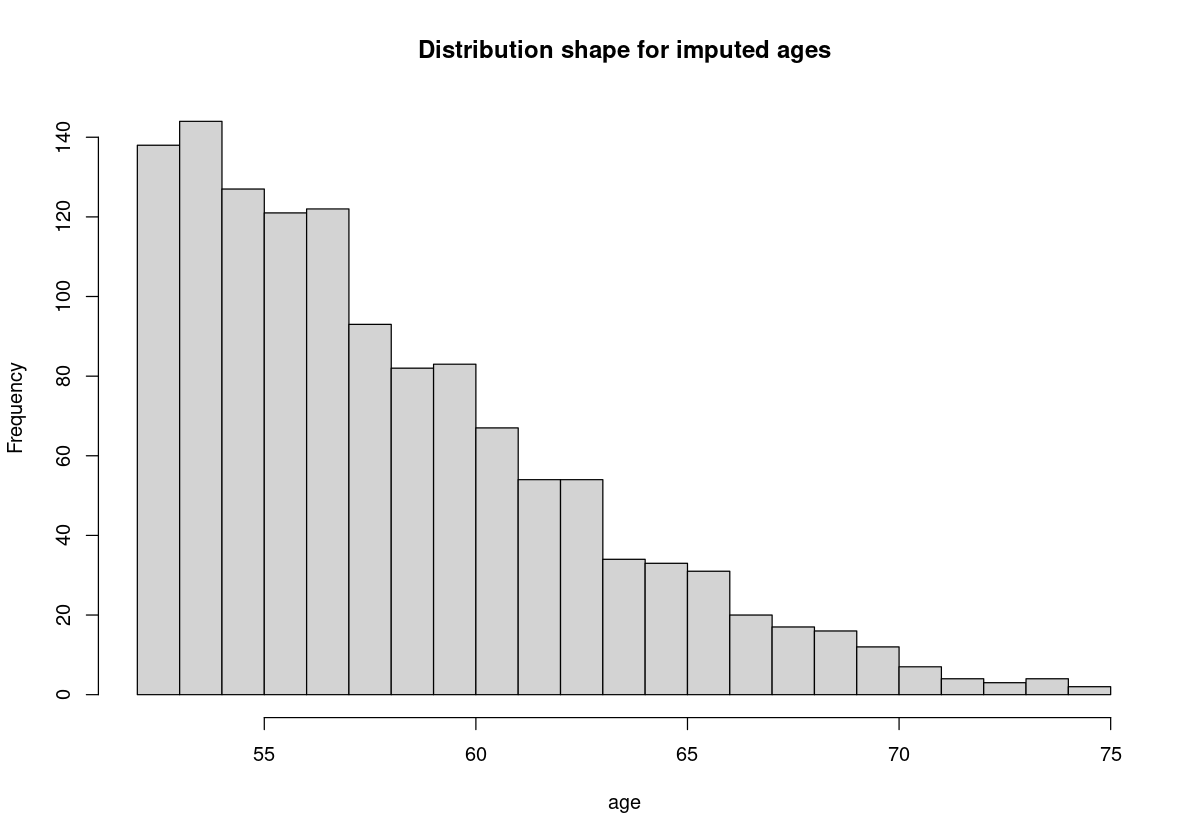

In [59]:
tmpdat <- dat[which(dat$housing_median_age >= 52), c("housing_median_age"),
              drop=FALSE]
nrow(tmpdat)
tmpdat$housing_median_age <- as.factor(round(tmpdat$housing_median_age))
table(tmpdat$housing_median_age)

options(repr.plot.width= 10, repr.plot.height= 7)
hist(dat[which(dat$housing_median_age >= 52), c("housing_median_age")],
     breaks=25, xlab="age", main="Distribution shape for imputed ages")


## Final Comments for Appendix A

The basic problem facing us with the capped data is that we need to impute values into a region for which we have no data.  And if the model we build for predicting housing_median_age has no data to work with in the region where the imputed values should lie, this model will nearly always generate predictions within the range of the data from which it was built.  The Gibbs sampler provides us with a solution to this problem.  But it is not a solution we should always accept without adjustments, for it can only yield a distribution for the imputed values that is the same as that built into our model assumptions for the response variable.

With the censored housing median age values, we are imputing values at the tail of the distribution.  Thus, we do not expect the imputed values to have a normal distribution.  We can get a better handle on the true, unobserved distribution if we can accurately predict the mean and/or median.  An accurate prediction not only tells us something about how fast the counts are dropping, but also something about how good the unadjusted output from the Gibbs sampler is.

In this appendix I have offered a *general* method for getting a good prediction of the mean of the true, unobserved values of the censored records.  We see another application of the method in Appendix B.  With an accurate prediction of the mean, we can adjust the Gibbs sampler output, if necessary, to fit the shape of the distribution of imputed values that we expect to see.  We end up with a much more plausible set of imputed values.  In fact, the imputed values are plausible enough that for certain purposes we can treat them as if they were observed data.  This is exactly what I do with the imputed values for the 4.8\% of the records with a censored median house value when I compute comparative root mean square error (rmse) scores.  The average error for our predictions for median house value then becomes an average over **all** Census districts in California and not just those with an expected median house value less than 500K.


